# Описание проекта

Интернет-магазин продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, об оценках пользователей и экспертов, о жанрах и платформах. Необходимо выявить закономерности, определяющие успешность игры.

Данные представлены до 2016 года включительно (за 2016 год - могут быть неполными). Рекламная кампания планируется на 2017-й год.

ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр.

### Примечание

Подразумевается, что данное исследование проводилось в конце 2016 - начале 2017 года. Поэтому такие формулировки, как "сегодня", "сейчас", "в настоящее время" и т.п. следует понимать как указание на время проведения исследования, а не на реальное настоящее время.

# Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
sns.set()
sns.set_color_codes()

## Просмотр файла с данными

Загрузим датасет из файла и откроем его, а также посмотрим описание.

In [3]:
games = pd.read_csv('./games.csv')
games.head(30)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Данные распознались корректно.

Много пропусков в столбцах с рейтингом (*Critic_Score*, *User_Score*, *Rating*), - с ними нужно будет разобраться. В остальном - данные в хорошем состоянии. Требуется провести предобработку.

## Замена названий столбцов

Уберём заглавные буквы из названий столбцов.

Сохраним список столбцов в переменной. Скорее всего, он ещё понадобится.

In [5]:
cols_all = games.columns.str.lower()
games.columns = cols_all
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Создадим списки с именами характерных групп столбцов.

In [6]:
cols_main = cols_all[0:4]
cols_sales = cols_all[4:8]
cols_score = cols_all[8:11]
(cols_main, cols_sales, cols_score)

(Index(['name', 'platform', 'year_of_release', 'genre'], dtype='object'),
 Index(['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], dtype='object'),
 Index(['critic_score', 'user_score', 'rating'], dtype='object'))

## Удаление некорректных строк

Под некорректными здесь понимаются те строки, в которых отсутствует существенная информация: имеются пропуски в столбцах кроме рейтинговых. Таких строк - немного (около 1,5%), и информация в них не подлежит восстановлению.

Даже год выпуска игры по её названию (названия игр часто содержат год) не всегда можно установить достоверно: он может быть как текущий, так и следующий. А иногда - выдуманный. Вот пример, когда "год" в названии не связан с годом выпуска игры.

In [7]:
games.query('name == "SimCity 2000"')[['name', 'year_of_release']].head()

,name,year_of_release
769,SimCity 2000,1992.0
1646,SimCity 2000,1996.0
4066,SimCity 2000,1995.0
6219,SimCity 2000,1994.0
10408,SimCity 2000,2003.0


Поэтому строки с такими пропусками следует удалить. Удалим их.

In [8]:
games.dropna(subset=['name', 'year_of_release', 'genre'], inplace=True)
games.reset_index(drop=True, inplace=True)
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Пропуски в столбцах с рейтингами проанализируем позже.

## Удаление дубликатов (этап 1)

Если в таблице есть дубликаты, их также необходимо удалить.

In [9]:
games.duplicated().sum()

0

Дубликатов целых строк нет, но для проверки этого недостаточно. Задублироваться могли первые четыре столбца из-за проблем в процессе подтягивания данных о продажах и рейтинге. Вот пример.

In [10]:
games[games[['name', 'platform', 'year_of_release', 'genre']].duplicated(keep=False) == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
600,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
15969,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Чтобы выявить все подобные случаи, необходимо для начала проработать эти столбцы на наличие аномалий, ошибок, проблем с типом данных и т.д. Сейчас пока даже этот пример трогать не будем, а позже обработаем сразу все подобные дубликаты.

## Проверка столбцов на аномалии, выбросы, ошибки

### Столбец *name*

In [11]:
games['name'].value_counts().count()

11426

Более 11 тыс. уникальных значений. Это означает, что некоторые названия встречаются несколько раз. Такое может быть, когда игра реализована для нескольких платформ.

Больше здесь ничего проверить не получится: названий слишком много для ручной проработки. А поскольку мы имеем дело с именами собственными, критериев, позволяющих автоматизировать проверку, тоже нет.

Поэтому будем исходить из того, что все названия - правильные, и опечаток там нет.

### Столбец *platform*

Проверим, есть ли здесь неявные дубликаты.

In [12]:
games['platform'].value_counts().sort_index()

2600     116
3DO        3
3DS      512
DC        52
DS      2121
GB        97
GBA      811
GC       542
GEN       27
GG         1
N64      316
NES       98
NG        12
PC       957
PCFX       1
PS      1190
PS2     2127
PS3     1306
PS4      392
PSP     1193
PSV      429
SAT      173
SCD        6
SNES     239
TG16       2
WS         6
Wii     1286
WiiU     147
X360    1232
XB       803
XOne     247
Name: platform, dtype: int64

Всё в порядке.

Есть несколько платформ, для которых реализовано всего лишь по несколько игр. Сформируем список с их названиями и выведем строки.

In [13]:
few_amount = 15  # В списке выводятся игры для тех платформ, в которых количество игр меньше значения этой переменной.

few_index = games.pivot_table(index='platform', values='name', aggfunc='count') \
                 .sort_values('name') \
                 .query('name < @few_amount') \
                 .index \
                 .tolist()
few_index

['GG', 'PCFX', 'TG16', '3DO', 'WS', 'SCD', 'NG']

In [14]:
games.query('platform in @few_index').sort_values(by='platform')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
12465,Policenauts,3DO,1995.0,Adventure,0.0,0.00,0.06,0.00,NaN,NaN,NaN
15313,Sotsugyou II: Neo Generation Special,3DO,1995.0,Simulation,0.0,0.00,0.02,0.00,NaN,NaN,NaN
14837,Bust-A-Move,3DO,1994.0,Puzzle,0.0,0.00,0.02,0.00,NaN,NaN,NaN
13360,Sonic the Hedgehog 2 (8-bit),GG,1992.0,Platform,0.0,0.00,0.04,0.00,NaN,NaN,NaN
11929,Samurai Shodown,NG,1993.0,Fighting,0.0,0.00,0.07,0.00,NaN,NaN,NaN
11350,Samurai Shodown III,NG,1995.0,Fighting,0.0,0.00,0.08,0.00,NaN,NaN,NaN
9558,The King of Fighters '94,NG,1994.0,Fighting,0.0,0.00,0.12,0.00,NaN,NaN,NaN
9057,The King of Fighters '94 (CD),NG,1993.0,Fighting,0.0,0.00,0.14,0.00,NaN,NaN,NaN
12622,The King of Fighters '96,NG,1996.0,Fighting,0.0,0.00,0.06,0.00,NaN,NaN,NaN
15408,Super Dodge Ball,NG,1995.0,Sports,0.0,0.00,0.02,0.00,NaN,NaN,NaN


В некоторых случаях, чтобы сократить перечень уникальных значений столбца, от подобных строк можно было бы избавиться вовсе либо заменить разрозненные значения на какое-то общее вроде "другие".

Но в данном случае так делать не следует. Мы видим, что эти игры были выпущены в девяностые годы для японского рынка. Тогда выпускалось значительно меньше игр, чем в более позднее время: вспомним, как резко росла производительность ПК в первой половине нулевых. Это отражалось и на играх тоже. У платформ есть определённый срок жизни, и некоторые из них, в том числе эти, могли "не застать" большое колчество игр.

Поэтому, чтобы не навредить данным, ничего здесь менять не будем. Это можно будет сделать позже по мере необходимости.

### Столбец *year_of_release*

In [15]:
games['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983.])

Всё в порядке.

### Столбец *genre*

Проверим, есть ли здесь неявные дубликаты.

In [16]:
games['genre'].value_counts().sort_index()

Action          3307
Adventure       1293
Fighting         837
Misc            1721
Platform         878
Puzzle           569
Racing          1226
Role-Playing    1481
Shooter         1296
Simulation       857
Sports          2306
Strategy         673
Name: genre, dtype: int64

Дубликатов нет. Ошибок тоже нет, всё нормально.

### Столбцы *na_sales*, *eu_sales*, *jp_sales*, *other_sales*

Для начала проверим, нет ли в столбцах отрицательных значений.

In [17]:
games[cols_sales].min()

na_sales       0.0
eu_sales       0.0
jp_sales       0.0
other_sales    0.0
dtype: float64

Отрицательных значений нет.

В этих столбцах много нулей. Ноль означает, что соответствующая ему комбинация "игра-платформа" не была представлена на данном рынке. Поэтому посмотрим раздельно количество в столбце нулей и описание данных столбца без нулей.

In [18]:
for col in cols_sales:
    describe_above_zero = games[games[col]>0.0][col].describe()
    zero_count = len(games[col]) - describe_above_zero['count']
    print('Столбец {}. Нулей: {} ({:.1%})'.format(col, zero_count, zero_count / len(games[col]))) 
    print(describe_above_zero)
    print('')

Столбец na_sales. Нулей: 4449.0 (27.1%)
count    11995.000000
mean         0.361936
std          0.939536
min          0.010000
25%          0.060000
50%          0.140000
75%          0.340000
max         41.360000
Name: na_sales, dtype: float64

Столбец eu_sales. Нулей: 5766.0 (35.1%)
count    10678.000000
mean         0.224731
std          0.614583
min          0.010000
25%          0.020000
50%          0.070000
75%          0.200000
max         28.960000
Name: eu_sales, dtype: float64

Столбец jp_sales. Нулей: 10300.0 (62.6%)
count    6144.000000
mean        0.210065
std         0.481057
min         0.010000
25%         0.030000
50%         0.070000
75%         0.190000
max        10.220000
Name: jp_sales, dtype: float64

Столбец other_sales. Нулей: 6492.0 (39.5%)
count    9952.000000
mean        0.078640
std         0.236567
min         0.010000
25%         0.010000
50%         0.020000
75%         0.070000
max        10.570000
Name: other_sales, dtype: float64



Во всех столбцах есть одна и та же особенность: максимум - на два порядка больше, чем третий квартиль. Скорее всего, это высокомонетизированные игры последних лет выпуска.

Убедимся, что это не отдельные выбросы.

In [19]:
for col in cols_sales:
    print(games[col].sort_values(ascending=False).head(15))
    print('')

0     41.36
1     29.08
9     26.93
5     23.20
2     15.68
3     15.61
14    15.00
8     14.44
7     13.96
18    12.78
6     11.28
4     11.27
21    10.83
11     9.71
32     9.70
Name: na_sales, dtype: float64

0     28.96
2     12.76
10    10.95
3     10.93
19     9.20
7      9.18
6      9.14
16     9.09
4      8.89
15     8.49
13     8.03
11     7.47
8      6.94
85     6.42
42     6.31
Name: eu_sales, dtype: float64

4      10.22
12      7.20
1       6.81
6       6.50
20      6.04
27      5.65
25      5.38
43      5.33
26      5.32
214     4.87
8       4.70
73      4.39
152     4.35
33      4.35
5       4.22
Name: jp_sales, dtype: float64

17     10.57
0       8.45
48      7.53
16      3.96
2       3.29
3       2.95
348     2.93
6       2.88
7       2.84
10      2.74
434     2.46
34      2.42
31      2.38
8       2.24
13      2.15
Name: other_sales, dtype: float64



Прослеживается плавная тенденция. Похоже, это действительно не выбросы, а реальные данные о продажах.

### Столбец *critic_score*

In [20]:
games['critic_score'].describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Столбец *critic_score* находится в пределах, указанных в описании данных. Аномалий нет.

Проверим пропуски.

In [21]:
games['critic_score'].isna().sum()

8461

Пропуски - примерно в половине строк. Столько удалять нельзя. Но и заполнить их тоже нечем: информация отсутствует, и восстановить её, прямо или косвенно, не представляется возможным. Вместе с тем, часть пропусков - и не пропуски вовсе: возможно, рейтинг в некоторых ситуациях (года, рынки, платформы) ещё не присваивали, а начали делать это позже.

Здесь, а также в других столбцах с рейтингом, пропуски будем заполнять условным значением "-1". Это позволит удобно обрабатывать столбец в дальнейшем, а указание на отсутствие значения - не потеряется.

In [22]:
# The function fills NaNs and returns its amount for checking

def fillna_func(col, value):
    games[col].fillna(value, inplace=True)
    return games[col].isna().sum()

In [23]:
fillna_func('critic_score', -1)

0

### Столбец *user_score*

Столбец *user_score* имеет пока ещё нечисловой тип данных. Есть информация о встречающейся аббревиатуре "tbd". Необходимо проверить наличие её, а также других подобных значений.

In [24]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Есть только ячейки со строкой "tbd". Других нечисловых значений нет.

Рассмотрим строки с аббревиатурой "tbd". Составим сводную таблицу, где заполненные строки будут сгруппированы независимо от своего значения как "numeric". Наряду с "numeric" строки в сводной таблице будут также для пропусков и "tbd". Проверим, есть ли характерные различия в продажах на разных рынках и по году выпуска.

In [25]:
games_tbd_check = games.copy()

numeric_idxs = games_tbd_check[(pd.isna(games_tbd_check['user_score']) == False) 
                               & (games_tbd_check['user_score'] != 'tbd')]['user_score'].index

games_tbd_check.loc[numeric_idxs, 'user_score'] = 'numeric'
games_tbd_check['user_score'].fillna('nan', inplace=True)

games_tbd_check.pivot_table(index='user_score', 
                            values=['year_of_release', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales'], 
                            aggfunc={'year_of_release': ['min', 'max', 'count'],
                                     'na_sales': 'sum',
                                     'eu_sales': 'sum',
                                     'jp_sales': 'sum',
                                     'other_sales': 'sum'}
                            )

eu_sales jp_sales na_sales other_sales year_of_release          \
                sum      sum      sum         sum           count     max   
user_score                                                                  
nan          607.93   836.95  1227.71      149.06            6605  2016.0   
numeric     1687.98   447.08  2815.43      595.78            7463  2016.0   
tbd          103.77     6.61   298.28       37.79            2376  2016.0   

                    
               min  
user_score          
nan         1980.0  
numeric     1985.0  
tbd         1997.0

Характерных различий нет. Продажи на японском рынке - низкие, но не нулевые. Самый ранний год присвоения - 1997. Не самое начало игровой эпохи, но и не новшество. Количество "tbd" - сопоставимое с остальными категориями.

Поскольку никакой информации о категории "tbd" найти не удалось, оставим её как есть, чтобы не искажать данные.

Заполним пропуски значением "-1", как описывалось выше. Значения "tbd" заполним другим условным значением - "-2".

In [26]:
fillna_func('user_score', '-1')

0

In [27]:
games['user_score'].where(games['user_score'] != 'tbd', other='-2', inplace=True)
games['user_score'].unique()

array(['8', '-1', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '-2', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

### Столбец *rating*

In [28]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Ознакомившись с информацией о ESRB из открытых источников, можно сделать вывод о наличии неявных дубликатов: некоторые категории имели разные названия в разные годы.

Создадим словарь. Пронумеруем категории, установим соответствие между идентичными категориями, приведём расшифровку (минимальный возраст), год начала присваивания.

In [29]:
#Словарь с категориями рейтинга ESRB:
# key - рейтинг ESRB
# value[0] - присвоенный нами номер категории
# value[1] - минимальный разрешённый возраст
# value[2] - год начала присваивания категории
# value[3] - текущий год

current_year = 2020 #Текущий год. Не динамический, так как классификация может устареть.

rating_cat = {
    'EC'  : [0, 3, 1994, 2018],
    'K-A' : [1, 6, 1994, 1997],
    'E'   : [1, 6, 1998, current_year],
    'E10+': [2, 10, 2005, current_year],
    'T'   : [3, 13, 1994, current_year],
    'M'   : [4, 17, 1994, current_year],
    'AO'  : [5, 18, 1994, current_year],
    'RP'  : [6, 0, 1994, current_year]
}

Создадим столбец *rating_cat*, содержащий категории рейтинга ESRB согласно словарю rating_cat. Пропуски в обоих столбцах заполним условным значением "-1".

In [30]:
# The function creates the "rating_cat" column containing the ESRB category numbers according to the rating_cat dictionary
# NaNs are filled with "-1"

def rating_cat_func(x):
    out = -1
    for cat in rating_cat.keys():
        if x['rating'] == cat:
            out = rating_cat[cat][0]
    return out

games['rating_cat'] = games.apply(rating_cat_func, axis=1)

In [31]:
fillna_func('rating', '-1')

0

Проверим результат.

In [32]:
games.groupby('rating')['rating'].count()

rating
-1      6676
AO         1
E       3921
E10+    1393
EC         8
K-A        3
M       1536
RP         1
T       2905
Name: rating, dtype: int64

In [33]:
games.groupby('rating_cat')['rating_cat'].count()

rating_cat
-1    6676
 0       8
 1    3924
 2    1393
 3    2905
 4    1536
 5       1
 6       1
Name: rating_cat, dtype: int64

Заполнение столбца *rating_cat* выполнено без ошибок: категории присвоены корректно.

ESRB была основана в 1994 году. Посмотрим, сколько имеется пропусков за 1994 год и позже.

In [34]:
games.query('year_of_release >= 1994').count().max()

16079

In [35]:
games.query('year_of_release >= 1994 & rating_cat == -1').count().max()

6315

До 1994 года было создано менее 400 игр. Поэтому большинство пропусков, как и большинство самих игр, - за более поздние года.

А есть ли рейтинг ESRB у игр, выпущенных до 1994 года?

In [36]:
games.query('year_of_release < 1994 & rating_cat != -1')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_cat
2575,The 7th Guest,PC,1992.0,Adventure,0.02,0.77,0.0,0.00,-1.0,-1,T,3
14241,Alter Ego,PC,1985.0,Simulation,0.00,0.03,0.0,0.01,59.0,5.8,T,3
14379,Doom,PC,1992.0,Shooter,0.02,0.00,0.0,0.00,85.0,8.2,M,4
14390,SimCity,PC,1988.0,Simulation,0.00,0.02,0.0,0.01,64.0,2.2,E10+,2


В общем-то, нет ничего удивительного (и уж тем более это - не ошибка), что ребята из ESRB присвоили рейтинг некоторым "старым" игрушкам.

## Приведение типов данных

In [37]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null float64
user_score         16444 non-null object
rating             16444 non-null object
rating_cat         16444 non-null int64
dtypes: float64(6), int64(1), object(5)
memory usage: 1.5+ MB


Все пропуски заполнены, и теперь можно выполнить приведение типов.

Год выпуска *year_of_release* и оценка критиков *critic_score* должны быть целочисленными, так как являются дискретными переменными. *critic_score* так же, как и год выпуска, имеет шаг, равный единице.

Оценка пользователей *user_score* должна быть вещественной, так как содержит дробную часть.

In [38]:
games['year_of_release'] = games['year_of_release'].astype('int')
games['critic_score'] = games['critic_score'].astype('int')
games['user_score'] = games['user_score'].astype('float')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int32
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null int32
user_score         16444 non-null float64
rating             16444 non-null object
rating_cat         16444 non-null int64
dtypes: float64(5), int32(2), int64(1), object(4)
memory usage: 1.4+ MB


In [39]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_cat
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,1
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,-1,-1
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,1
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,1
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,-1,-1


Теперь во всех столбцах типы данных - такие, какие нужно.

Дополнительно проверим столбец *user_score* как вещественный на наличие аномалий. При этом отфильтруем условные значения.

In [40]:
games.query('user_score != -1 & user_score != -2')['user_score'].describe()

count    7463.000000
mean        7.126330
std         1.499447
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

Всё в порядке.

## Удаление дубликатов (этап 2)

Пришла пора найти и обработать неявные дубликаты. Под неявными дубликатами понимаются такие строки, которые по своему смыслу должны быть одной строкой. В разделе "Удаление дубликатов (этап 1)" можно увидеть пример такого дубликата. Поскольку в некоторых столбцах имеются отличия, метод duplicated(), применённый ко всей строке, не выявит такое. 

Будет корректно объединить такие строки по следующему принципу:
* сравниваемые строки должны быть постолбцово равны между собой, за исключением столбцов с объёмами продаж;
* столбцы с объёмами продаж суммируются построчно, и полученные суммы присваиваются первой строке из списка;
* все строки, кроме первой, удаляются.

Этот принцип работы заложен в функцию drop_implicit_duplicates.

In [41]:
# The function drops the implicit duplicates

def drop_implicit_duplicates(cols_main_list, cols_sales_list=cols_sales, cols_score_list=cols_score):
    ids = games[games[cols_main_list].duplicated(keep=False) == True].index
    for i in range(1, len(ids), 1):
        if sum(games.loc[ids[0], cols_score_list] == games.loc[ids[i], cols_score_list]) == len(cols_score_list):
            games.loc[ids[0], cols_sales_list] = games.loc[[ids[0], ids[i]], cols_sales_list].sum()
            games.drop(ids[i], inplace=True)
            games.reset_index(drop=True, inplace=True)
            print('row {} deleted'.format(ids[i]))
    print('')

Выявим неявные дубликаты в первых четырёх столбцах.

In [42]:
games[games[cols_main].duplicated(keep=False) == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_cat
600,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83,5.5,E,1
15969,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83,5.5,E,1


In [43]:
drop_implicit_duplicates(cols_main)
games.info()

row 15969 deleted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 12 columns):
name               16443 non-null object
platform           16443 non-null object
year_of_release    16443 non-null int32
genre              16443 non-null object
na_sales           16443 non-null float64
eu_sales           16443 non-null float64
jp_sales           16443 non-null float64
other_sales        16443 non-null float64
critic_score       16443 non-null int32
user_score         16443 non-null float64
rating             16443 non-null object
rating_cat         16443 non-null int64
dtypes: float64(5), int32(2), int64(1), object(4)
memory usage: 1.4+ MB


In [44]:
games.loc[[600]]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_cat
600,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.0,0.23,83,5.5,E,1


Функция отработала корректно.

Необходимо проверить аналогичным образом первые два столбца - *name* и *platform*. Одна и та же игра для одной и той же платформы не может выйти в разные годы и/или в разных жанрах одновременно. Впрочем, сначала посмотрим вручную.

In [45]:
games[games.loc[:, ['name', 'platform']].duplicated(keep=False) == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_cat
1177,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83,8.5,T,3
1574,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83,8.5,T,3
5883,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82,8.5,T,3
11534,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82,8.5,T,3


Первые четыре столбца в совокупности выглядят немного противоречиво, чтобы агрегировать их сразу, - необходимо разобраться. Поскольку выявлена только одна игра, есть возможность обратиться к открытым источникам. Краткий обзор показал, что всё не так просто. Это действительно одна и та же игра, изначально выпущенная в 2005 году и перевыпущенная в 2012 году другой компанией. Вероятно, на две платформы. Совпадение рейтинга здесь - случайность, тем более различается он незначительно.

Вносить изменения в название игры, пытаясь повысить точность, смысла не имеет. Эти четыре строки оставим как есть.

## Добавление столбца с суммарными продажами

In [46]:
games['total_sales'] = games[cols_sales].sum(axis=1)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_cat,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,1,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,-1,-1,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,1,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,1,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,-1,-1,31.38


## Причины возникновения пропусков

Все пропуски сосредоточены только в столбцах с рейтингами - *critic_score*, *user_score*, *rating_cat*. В других столбцах пропусков нет (за исключением тех немногих, что были удалены сразу).

Чтобы понять причины, которые привели к возникновению пропусков, необходимо проанализировать их количество в динамике по годам. Поскольку игр в разные годы выпускалось тоже разное количество, будет информативнее рассматривать относительные величины: отношение количества игр с тем или иным рейтингом к общему количеству игр, выпущенных за год.

Для этого сформируем сводную таблицу. Индекс - годы. Столбцы - количество игр всего; количество игр с присвоенным рейтингом (три вида рейтинга - три столбца); отношения трёх последних к первому (ещё три столбца).

Визуализируем полученные относительные величины с помощью линейного графика. В одной системе координат построены три линии - три относительных количества игр с рейтингом. Теперь есть наглядное представление о количестве присвоенных рейтингов.

In [47]:
nan_check_cols=['critic_score', 'user_score', 'rating_cat']

nan_check = games.copy()
nan_check = nan_check.loc[:, ['name', 'year_of_release'] + nan_check_cols]
nan_check[nan_check_cols] = nan_check[nan_check_cols].where(nan_check[nan_check_cols]==-1, other=0)
nan_check[nan_check_cols] = nan_check[nan_check_cols].abs().astype('int')
nan_check['name'] = 1
for col in nan_check_cols:
    nan_check[col] = nan_check['name'] - nan_check[col]

nan_check_pivot = nan_check.pivot_table(index='year_of_release', values=['name']+nan_check_cols, aggfunc='sum')
nan_check_pivot.reset_index(inplace=True)
nan_check_pivot = nan_check_pivot[['year_of_release', 'name', 'critic_score', 'user_score', 'rating_cat']]
nan_check_pivot.index = nan_check_pivot['year_of_release']
nan_check_pivot.drop('year_of_release', axis=1, inplace=True)
nan_check_pivot = nan_check_pivot.rename(columns={'name': 'games_amount'})

nan_check_cols_ratio = []
for col in nan_check_cols:
    nan_check_pivot[col+'_ratio'] = nan_check_pivot[col] / nan_check_pivot['games_amount']
    nan_check_cols_ratio.append(col+'_ratio')

nan_check_pivot

,games_amount,critic_score,user_score,rating_cat,critic_score_ratio,user_score_ratio,rating_cat_ratio
year_of_release,,,,,,,
1980,9,0,0,0,0.000000,0.000000,0.000000
1981,46,0,0,0,0.000000,0.000000,0.000000
1982,36,0,0,0,0.000000,0.000000,0.000000
1983,17,0,0,0,0.000000,0.000000,0.000000
1984,14,0,0,0,0.000000,0.000000,0.000000
1985,14,1,1,1,0.071429,0.071429,0.071429
1986,21,0,0,0,0.000000,0.000000,0.000000
1987,16,0,0,0,0.000000,0.000000,0.000000
1988,15,1,1,1,0.066667,0.066667,0.066667


In [48]:
# The function sets the format of the X-axis for the years

def year_ax_format(df, step=2, angle=30, height=8, return_ax=False):
    fig = None
    ax = None
    
    if return_ax:
        fig, ax = plt.figure(figsize=(16, height))
    else:
        plt.figure(figsize=(16, height))

    plt.xlim(df.index.min(), df.index.max()+1)
    plt.xticks(range(df.index.min(), df.index.max()+1, step), rotation=angle)
    return fig, ax

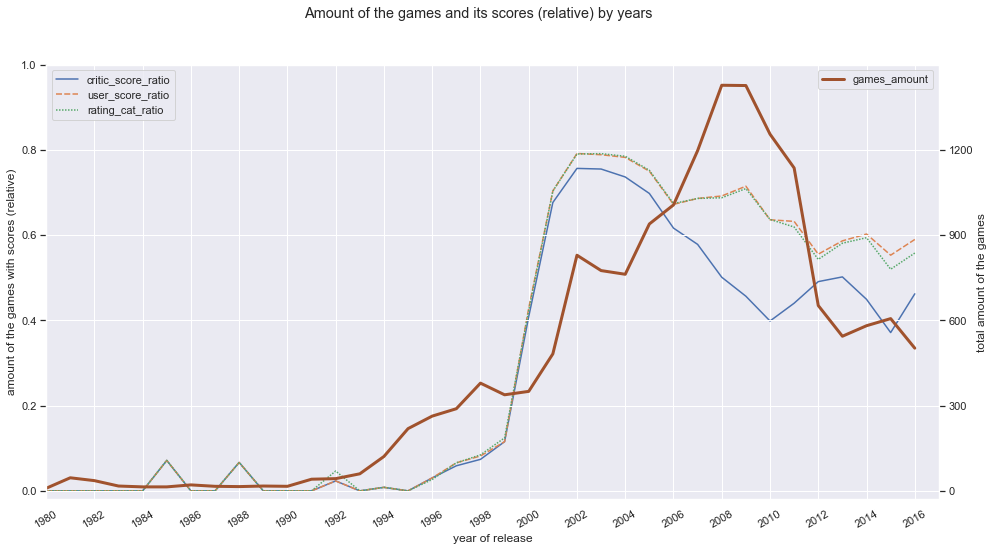

In [49]:
years_label = 'year of release'

year_ax_format(nan_check_pivot)
plt.suptitle('Amount of the games and its scores (relative) by years')

sns.lineplot(data=nan_check_pivot[nan_check_cols_ratio])
plt.ylim(-0.02, 1) #Нижний предел выбран таковым для наглядности картинки, верхний - для понимания масштаба
plt.legend(loc=2)
plt.xlabel(years_label)
plt.ylabel('amount of the games with scores (relative)')

plt.twinx()
sns.lineplot(data=nan_check_pivot['games_amount'], lw=3, color='sienna')
plt.ylim(-30, 1500)
plt.yticks(range(0, 1500, 300))
plt.legend(labels=['games_amount'], loc=1)
plt.ylabel('total amount of the games')

plt.show()

В рассматриваемом контексте каждый пропуск - это отсутствие рейтинга или оценки. Игре не присвоили рейтинг. Игру не оценили. На игру не написали отзыв и т.д. Поэтому, чтобы понять причины возникновения пропусков, следует разобраться в причинах, почему игры не всегда оценивали.

До середины девяностых годов компьютерные игры были совсем не тем, что они представляют собой сейчас. Не существовало мощной индустрии с многомилионными корпорациями. Игры воспринимались так, как сегодня - виндусовский пасьянс. До середины девяностых ещё не сформировалась культура оценки компьютерных игр. Этому препятствовала и неразвитость интернета: затруднена коммуникация, и получается, что отзывы-рейтинги писать попросту негде и некому. "Горбики" на графике левее 1994 года - это всего четыре оценённые игры.

В 1994 году была основана ESRB. И мы видим, что начиная с 1995 года дело, как говорится, пошло. Игры начали оценивать. К процессу подключились и критики с пользователями. Однако, доля оценённых игр по-прежнему пока очень мала.

Первая половина нулевых отличалась многократным увеличением производительности компьютеров. Игры становились интереснее и уже имели мало общего с примитивными игрушками 80-90-х. Вместе с бурным развитием индустрии развивалось и сообщество. Результат мы видим на графике: резкое увеличение доли оценённых игр - появился интерес. В 2002-2003 четыре игры из пяти имели рейтинг ESRB и пользовательскую оценку. Чуть меньше - были охвачены мнением критиков.

После 2003 года тенденция сменилась на плавно убывающую и остаётся таковой по сей день. При этом доля игр, оценённых критиками (46% в 2016 году), несколько отстаёт от доли оценённых ESRB (56%) и пользователями (59%). Вероятно, критики не поспевают за всеми новинками или просто не считают нужным писать статьи обо всём подряд. Это видно из графика: в 2007-2010 годы было выпущено максимальное количество игр. При этом мы видим наибольшее отставание доли критиков от долей ESRB и пользователей.

Выглядит странно, что в последние несколько лет, в эпоху, когда отзывы и обзоры пишут буквально на всё (и все, кому не лень), около 40% игр не оценено. Это - много. Можно предположить, что в последнее время усилилось расслоение на популярные во всём мире высокомонетизированные игры и "малозаметные". И, если игру обошло вниманием даже ESRB (которое присваивает лишь возрастное ограничение, а не оценку "понравилось - не понравилось"), то логично, что и пользователи с критиками не станут, так сказать, спешить оценивать непопулярную игру.

Необходимо отметить, что мы говорим об оценках (их наличии или отсутствии), которые публикуются авторитетными организациями и изданиями в сфере компьютерных игр. Об официальных оценках. А обычные частные отзывы или обзоры наверняка существуют по всем продуктам, как популярным, так и не очень.

## Вывод по предобработке данных

Данные уже изначально были в достаточно хорошем состоянии Удалено 1,6% строк, в которых была пропущена критически важная информация.

Скорректированы названия столбцов, выполнены поиск и обработка дубликатов. Дубликатов целых строк - нет. Неявно была продублирована всего одна строка: выполнена агрегация и последующее удаление строки-дубля.

Выполнена проверка каждого столбца на наличие аномалий, выбросов, ошибочных значений. Проблем с данными нет, за исключением значительного количества пропусков в столбцах с рейтингами (*critic_score*, *user_score*, *rating*) и большого количества значений "tbd" в столбце *user_score*.

Пропуски обусловлены характером данных, а не, скажем, низким качеством их сбора или выгрузки. Они возникли не по техническим причинам. Отсутствие значений в столбцах с рейтингами имеет определённую природу и не является ошибкой. Вместе с тем, пропуски технически обработаны: им присвоено условное значение "-1".

Не представляется возможным установить, что означает аббревиатура "tbd". Такие ячейки обработаны аналогично пропускам: присвоено значение "-2". Так они "не потеряются", и их при этом можно будет отличить от пропусков.

Добавлен столбец *rating_cat*. В нём категории столбца *rating* обозначены числами. Это необходимо для удобства дальнейшей обработки. Кроме того, выявлен и учтён следующий факт: две категории из тех, что есть в *rating*, представляют собой на самом деле одну и ту же категорию, имевшую в разное время разные названия. В *rating_cat* они обозначены одним и тем же числом.

Приведение типов выполнено в соответствии со смыслом переменных: дискретные переменные, кратные единице (*year_of_release*, *critic_score*), приведены к типу int. Дискретная переменная, кратная 0,1 (*user_score*), приведена к типу float.

Добавлен столбец *total_sales* с суммами продаж по всем регионам.

# Исследовательский анализ данных

## 1. Количество игр, выпущенных в разные годы

Сгруппируем игры по годам выпуска, посчитаем их количество, визуализируем.

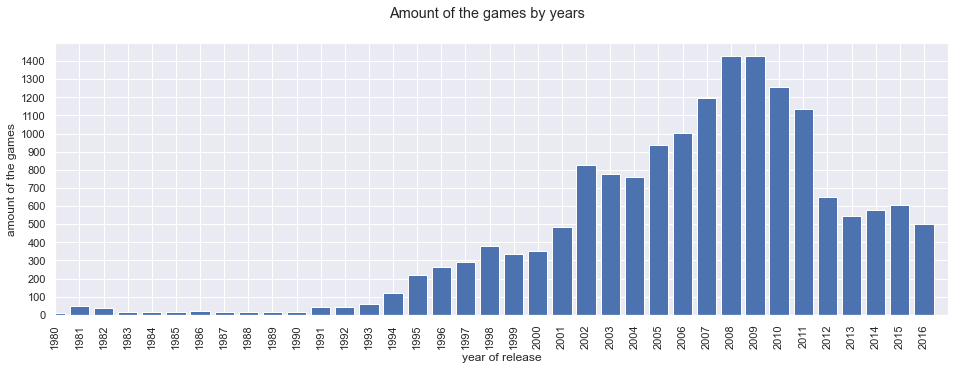

In [50]:
grouped_by_year = games.groupby('year_of_release')['name'].count()

year_ax_format(grouped_by_year, height=5, step=1, angle=90)
plt.suptitle('Amount of the games by years')

plt.bar(grouped_by_year.index, grouped_by_year)

plt.ylim(0, 1500)
plt.yticks(range(0, 1500, 100))
plt.xlabel(years_label)
plt.ylabel('amount of the games')

plt.show()

* С 1980 по 1992 год ежегодно выпускалось не более 50 игр.
* С 1993 года количество новых игр из года в год в среднем увеличивалось и в 2008 году составило более 1400.
* С 2009 года количество новых игр уменьшалось и к 2013 году составляло около 550. 
* Примерно таким оно остаётся с 2013 года по сегодняшний день.

Для построения прогноза на 2017 год необходимо взять данные за актуальный период. На графике можно выделить четыре характерных периода, различающиеся между собой тенденцией. Нас интересует последняя, актуальная на сегодняшний день установившаяся тенденция. Последний такой период начался в 2013 году: после крутого снижения наступила стабилизация. Оценивая визуально, можно отнести к этому периоду также 2012 год.

Данные за более ранние периоды не столь важны по двум причинам (возможно, взаимосвязанным):
* различия в тенденциях, описанные выше, чем-то обусловлены, а принимать во внимание факторы, уже утратившие актуальность, не стоит;
* платформы, существовавшие в прошлых периодах, ныне либо не существуют, либо находятся на последнем этапе своего жизненного цикла, поэтому данные по ним имеют гораздо меньший вес - вплоть до незначительного.

Таким образом, с позиции количества выпускаемых ежегодно игр **актуальный период - с 2012 по 2016 год** включительно и составляет **5 лет**.

## 2. Динамика продаж по различным платформам

### Годы максимальной выручки

Рассмотрим изменение объёма продаж по годам в разрезе платформ. Составим сводную таблицу. Визуализируем её и рассмотрим динамику.

In [51]:
sales_by_platforms = games.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
sales_by_platforms.tail()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012,NaN,NaN,51.36,NaN,11.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.22,NaN,NaN,NaN,107.36,NaN,7.69,16.19,NaN,NaN,NaN,NaN,NaN,21.71,17.56,99.74,NaN,NaN
2013,NaN,NaN,56.57,NaN,1.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.38,NaN,NaN,NaN,113.25,25.99,3.14,10.59,NaN,NaN,NaN,NaN,NaN,8.59,21.65,88.58,NaN,18.96
2014,NaN,NaN,43.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.28,NaN,NaN,NaN,47.76,100.00,0.24,11.90,NaN,NaN,NaN,NaN,NaN,3.75,22.03,34.74,NaN,54.07
2015,NaN,NaN,27.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.52,NaN,NaN,NaN,16.82,118.90,0.12,6.25,NaN,NaN,NaN,NaN,NaN,1.14,16.35,11.96,NaN,60.14
2016,NaN,NaN,15.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.25,NaN,NaN,NaN,3.60,69.25,NaN,4.25,NaN,NaN,NaN,NaN,NaN,0.18,4.60,1.52,NaN,26.15


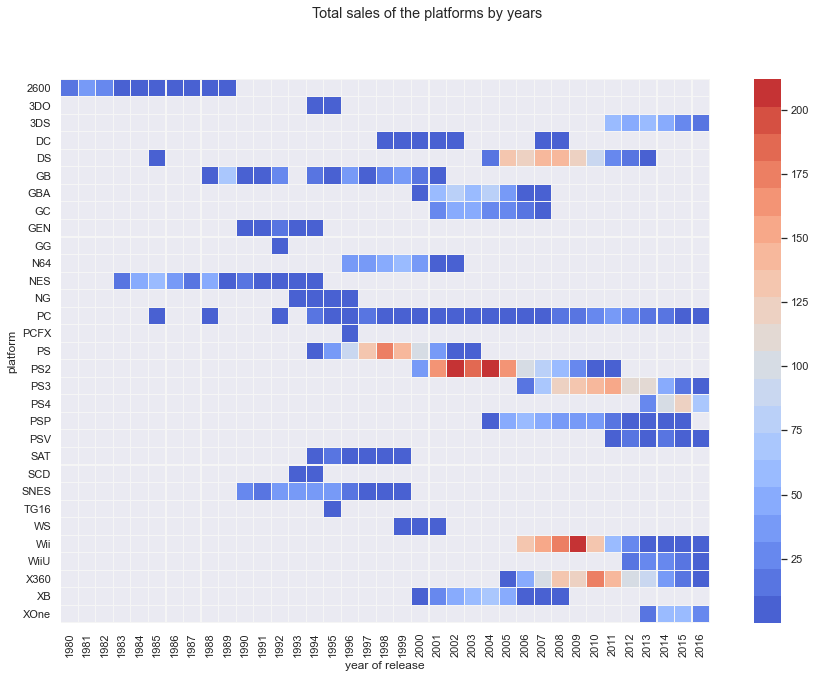

In [52]:
plt.figure(figsize=(16, 10))
plt.suptitle('Total sales of the platforms by years')

sns.heatmap(sales_by_platforms.transpose(), 
            cmap=sns.color_palette('coolwarm', 20),
            linewidth=0.1,
            square=True,
            linecolor='whitesmoke')

plt.xlabel(years_label)
plt.show()

По большинству платформ видно на графике, в какие годы какую выручку они приносили. Здесь отражены продажи в абсолютном выражении: можно сравнить выручку от разных платформ и найти топовые. **Максимальные продажи за всё рассматриваемое время** показали платформы ***Sony PlayStation* 1-4 поколений**, ***Nintendo Wii*** и ***Microsoft Xbox 360***.

Из-за того, что в разные годы (десятилетия) выручка от игр сильно разнилась, отличия в некоторых случаях составляют 2-3 порядка. Поэтому на данном графике не очень хорошо видны годы максимальной выручки по каждой платформе. Для более наглядного представления лучше обратиться к графику ниже.

### Определение характерной продолжительности жизненного цикла платформы

Для более качественной визуализации жизненного цикла платформ (а также годов максимальных продаж) перейдём к относительным величинам.

In [53]:
sales_by_platforms_relative = sales_by_platforms.copy()
for col in sales_by_platforms_relative.columns:
    sales_by_platforms_relative[col] = sales_by_platforms_relative[col] / sales_by_platforms_relative[col].max()
sales_by_platforms_relative.tail()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012,NaN,NaN,0.812658,NaN,0.074929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.662860,NaN,NaN,NaN,0.684781,NaN,0.139009,1.000000,NaN,NaN,NaN,NaN,NaN,0.104894,0.797095,0.586602,NaN,NaN
2013,NaN,NaN,0.895095,NaN,0.010480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353411,NaN,NaN,NaN,0.722350,0.218587,0.056761,0.654107,NaN,NaN,NaN,NaN,NaN,0.041504,0.982751,0.520967,NaN,0.315264
2014,NaN,NaN,0.692405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.379104,NaN,NaN,NaN,0.304631,0.841043,0.004338,0.735022,NaN,NaN,NaN,NaN,NaN,0.018119,1.000000,0.204317,NaN,0.899069
2015,NaN,NaN,0.439557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.243220,NaN,NaN,NaN,0.107284,1.000000,0.002169,0.386041,NaN,NaN,NaN,NaN,NaN,0.005508,0.742170,0.070341,NaN,1.000000
2016,NaN,NaN,0.239557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149872,NaN,NaN,NaN,0.022962,0.582422,NaN,0.262508,NaN,NaN,NaN,NaN,NaN,0.000870,0.208806,0.008940,NaN,0.434819


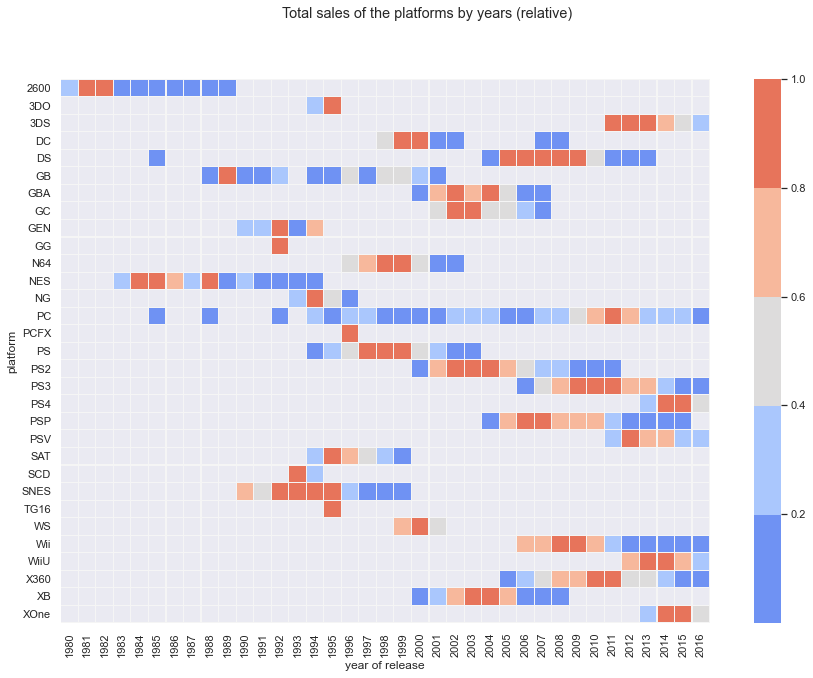

In [54]:
plt.figure(figsize=(16, 10))
plt.suptitle('Total sales of the platforms by years (relative)')

sns.heatmap(sales_by_platforms_relative.transpose(), 
            cmap=sns.color_palette('coolwarm', 5),
            linewidth=0.1, 
            square=True,
            linecolor='whitesmoke')

plt.xlabel(years_label)
plt.show()

Усреднённо **максимум выручки** платформа приносит в первой трети - второй четверти своего жизненного цикла - примерно **со 2-го по 5-й годы** своего существования.

Определим характерную продолжительность жизненного цикла платформы.

In [55]:
sales_by_platforms.count().agg(['mean', 'median'])

mean      7.677419
median    7.000000
dtype: float64

В расчёте учитывались все платформы: и те, которые отжили своё, и те, которые ещё живут, и те, которые "персональный компьютер", то есть вечные. Средняя и медианная продолжительность жизни составляет 7 и 8 лет соответственно (округляем до целого). Вместе с тем, уже отмечено, что максимум выручки приходится на вторую четверть жизни, и уже не столь важно, сколько длится после прохождения максимума "хвост" с низкой выручкой: плюс-минус 1-2 года - не критичная разница.

Рассмотрев в совокупности все эти факторы, принимаем: **характерная продолжительность жизни** платформы составляет **8 лет**.

### Платформы с наибольшими суммарными продажами

Определим платформы с наибольшими суммарными продажами за всё время и сделаем визуализацию.

In [56]:
sales_sum = sales_by_platforms.sum().sort_values(ascending=False)
sales_sum.head(10)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
dtype: float64

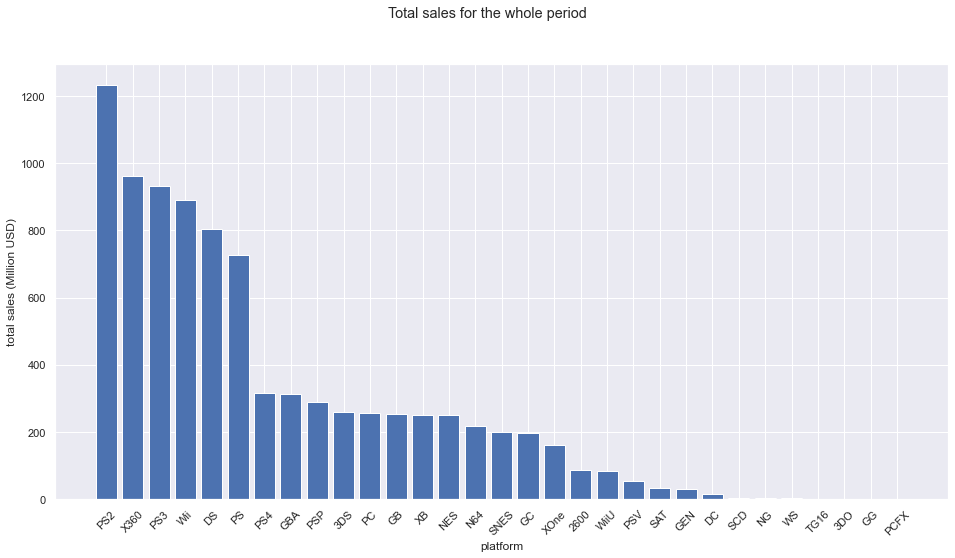

In [57]:
total_sales_label = 'total sales (Million USD)'

plt.figure(figsize=(16, 8))
plt.suptitle('Total sales for the whole period')

plt.bar(sales_sum.index, sales_sum)
plt.xticks(rotation=45)
plt.xlabel('platform')
plt.ylabel(total_sales_label)

plt.show()

Выделяется топ-6 платформ: *PS2*, *X360*, *PS3*, *Wii*, *DS*, *PS*. Построим распределение их выручки по годам.

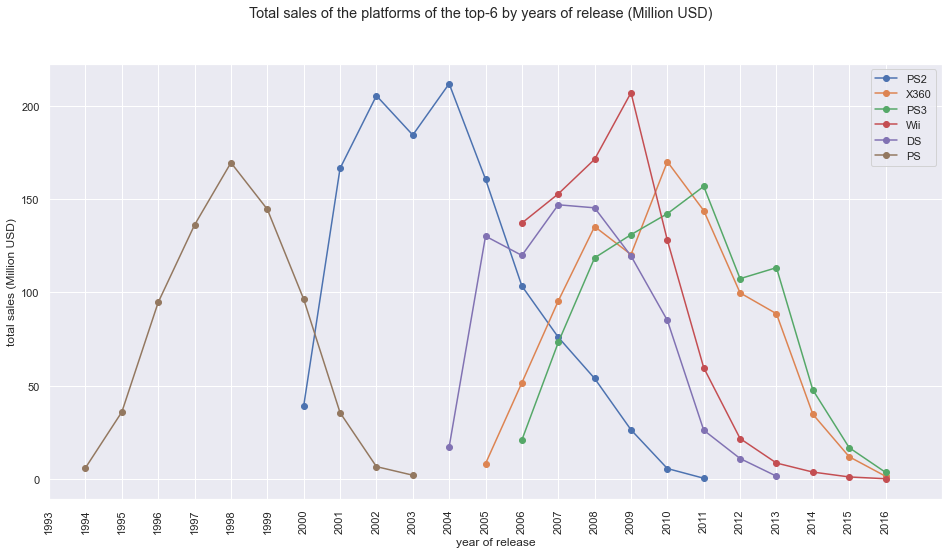

In [58]:
top6 = sales_sum.head(6).index.tolist()
top6_suptitle = 'Total sales of the platforms of the top-6 by years of release (Million USD)'

plt.figure(figsize=(16, 8))
plt.suptitle(top6_suptitle)

for i in range(len(top6)):
    #plt.bar(sales_by_platforms.index, sales_by_platforms[top6[i]], alpha=0.4, width=(i+1)*0.15)
    plt.plot(sales_by_platforms.index, sales_by_platforms[top6[i]], 'o-')
    plt.xlabel(years_label)
    plt.ylabel(total_sales_label)
    
plt.legend(top6)
plt.xticks(range(sales_by_platforms.index.min(), sales_by_platforms.index.max()+1), rotation=90)
plt.xlim(left=1993)
plt.show()

Для повышения наглядности построим также отдельные диаграммы.

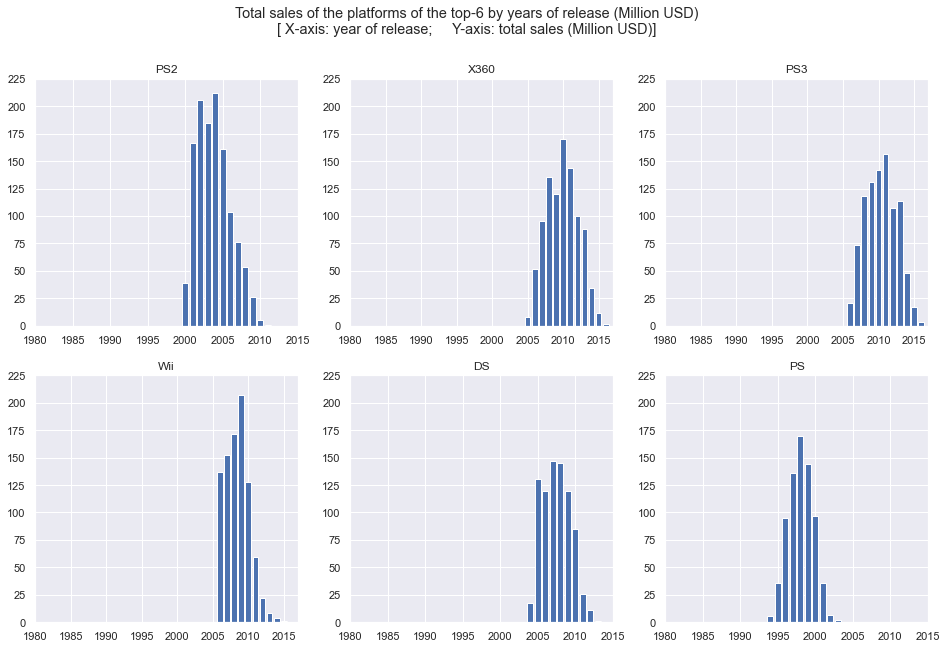

In [59]:
fig = plt.figure(figsize=(16, 10))
plt.suptitle('{}\n[ X-axis: {};     Y-axis: {}]'.format(top6_suptitle, years_label, total_sales_label))

ax = []
for i in range(len(top6)):
    ax.append(fig.add_subplot(2, 3, i+1))
    plt.bar(sales_by_platforms.index, sales_by_platforms[top6[i]])
    plt.xticks(range(sales_by_platforms.index.min(), sales_by_platforms.index.max(), 5))
    ystep = 25
    plt.yticks(range(0, int(np.ceil(sales_by_platforms[top6].max().max()))+ystep, ystep))
    plt.title(top6[i])

plt.show()

В самые успешные годы типичная топовая платформа показывает объём продаж порядка 100-200 млн. долл.

На графиках видно, что топовые платформы приносили высокую выручку примерно в течение 6-8 лет. Продолжительность их жизни - на пару лет больше. Соответственно, справедливо принять **характерную продолжительность** равной **8 лет**. Предыдущий вывод подтверждается и здесь.

##  3. Определение актуального периода

Объединяя полученные результаты, а именно:
* динамика количества ежегодно выпускаемых игр, актуальная в настоящее время, стабилизировалась с 2012 года - 5 лет назад;
* характерная продолжительность жизни платформы - 8 лет;
* максимальные продажи платформа показывает примерно с 3-го по 5-й год своего существования;
* самые топовые за всю рассматриваемую историю платформы приносили высокую выручку в течение 6-8 лет;
* последняя смена поколений платформ (ушло с рынка много старых, появилось много новых) произошла 4-6 лет назад (см. heatmap);
* данные за 2016 год могут быть неполными: итоги года ещё не окончательные, поэтому их не стоит рассматривать,

приходим к выводу, что **актуальный период** следует принять равным **4 годам: 2012-2015 годы включительно**.

In [60]:
relevant_bounds = (2012, 2015)

В дальнейшей работе рассматриваются данные только за актуальный период.

##  4. Определение потенциально прибыльных платформ

### Формирование выборки за актуальный период

Создадим датасет за актуальный период.

In [61]:
games_relevant = games[(games['year_of_release'] >= relevant_bounds[0]) & (games['year_of_release'] <= relevant_bounds[1])]
games_relevant.reset_index(drop=True, inplace=True)
games_relevant.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_cat,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,4,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,4,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,-1,-1,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1,-1.0,-1,-1,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83,5.3,M,4,13.79


In [62]:
games_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2383 entries, 0 to 2382
Data columns (total 13 columns):
name               2383 non-null object
platform           2383 non-null object
year_of_release    2383 non-null int32
genre              2383 non-null object
na_sales           2383 non-null float64
eu_sales           2383 non-null float64
jp_sales           2383 non-null float64
other_sales        2383 non-null float64
critic_score       2383 non-null int32
user_score         2383 non-null float64
rating             2383 non-null object
rating_cat         2383 non-null int64
total_sales        2383 non-null float64
dtypes: float64(6), int32(2), int64(1), object(4)
memory usage: 223.5+ KB


Определим размер выборки за актуальный период относительно размера исходной выборки.

In [63]:
'Размер выборки за актуальный период составляет {:.1%} от размера исходной.'\
.format(len(games_relevant) / len(games))

'Размер выборки за актуальный период составляет 14.5% от размера исходной.'

### Словари, списки, функции

In [64]:
# Dicts and lists for the next function

line_styles = ['bo-', 'go-', 'ro-', 'co-', 'mo-', 'ko-', 'bo--', 'go--', 'ro--', 'co--', 'mo--', 'ko--']

region_dict = {
    
    #key - присваивать параметру region
    #value[0] - использовать в suptitle (.capitalize()) и ylabel
    #value[1] - использовать в suptitle и ylabel
    #value[2] - имя столбца с продажами в исходном датасете и выборок из него
    
    'total': ['total', 'sales', 'total_sales'],
    'NA'   : ['sales', 'in NA region', 'na_sales'],
    'EU'   : ['sales', 'in EU region', 'eu_sales'],
    'JP'   : ['sales', 'in JP region', 'jp_sales']
}

In [65]:
# The function plots the linear diagram for the sales by years splitting by the platforms

def sales_by_years_plot(df_pivot, region):
    year_ax_format(df_pivot, step=1)
    plt.suptitle('{} {} for the relevant period by years of release (Million USD)'
                 .format(region_dict[region][0].capitalize(), region_dict[region][1]))
    
    legend = []

    for i in range(len(df_pivot.columns)):
        plt.plot(df_pivot.index, df_pivot.iloc[:, i], line_styles[i])
        legend.append(df_pivot.columns[i])

    plt.xlabel(years_label)
    plt.ylabel(region_dict[region][0])
    plt.legend(legend)
    plt.show()

In [66]:
# The function forms the pivot table for the sales sums in the chosen region
# for the relevant period splitting by the platforms

def platforms_by_years_pivot(df, region):
    return df.pivot_table(index='year_of_release', 
                          columns='platform', 
                          values=region_dict[region][2], 
                          aggfunc='sum')

### Исследование динамики продаж и определение потенциально прибыльных платформ

Сформируем сводную таблицу с суммарными продажами по всем регионам за актуальный период с разбивкой по платформам.

In [67]:
games_relevant_pivot = platforms_by_years_pivot(games_relevant, region='total')
games_relevant_pivot

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14


Построим график, показывающий динамику суммарных продаж с разбивкой по платформам.

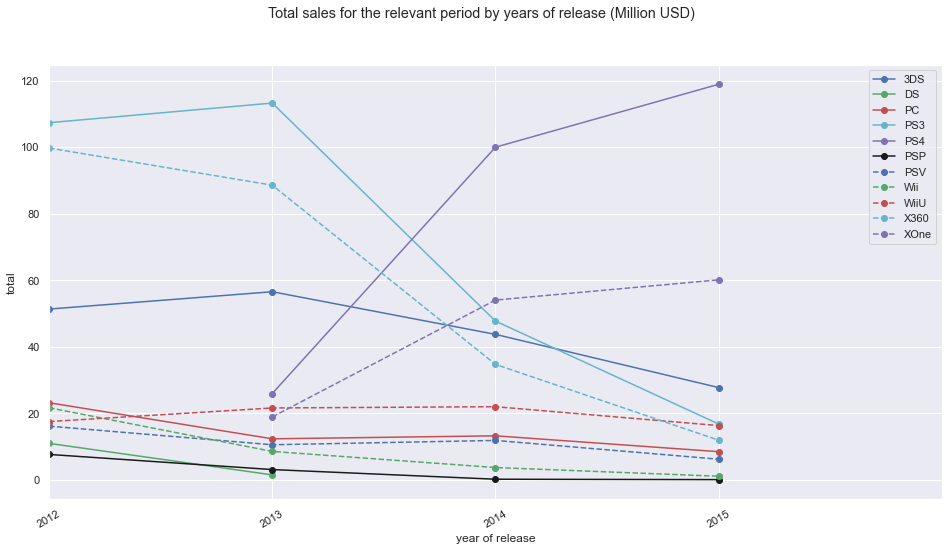

In [68]:
sales_by_years_plot(games_relevant_pivot, region='total')

Распределение первых трёх лидирующих мест по годам сведём в таблицу.

In [69]:
list_leaders = []
for year in games_relevant_pivot.index:
    list_leaders.append(games_relevant_pivot.loc[year].sort_values(ascending=False).head(3).index.tolist())

df_leaders = pd.DataFrame(index=games_relevant_pivot.index, columns=['1st', '2nd', '3rd'], data=list_leaders) \
               .transpose() \
               .rename_axis('place', axis=0)

df_leaders_columns = df_leaders.columns.tolist()
df_leaders_columns.sort(reverse=True)
df_leaders = df_leaders[df_leaders_columns]
df_leaders

year_of_release,2015,2014,2013,2012
place,,,,
1st,PS4,PS4,PS3,PS3
2nd,XOne,XOne,X360,X360
3rd,3DS,PS3,3DS,3DS


В последние два года лидируют *PS4* и *XOne*, причём *PS4* - со значительным отрывом. Они появились в продаже почти одновременно в 2013 году и очень быстро обрели высокую популярность, в течение года обогнав по продаже игр все остальные платформы. За первые свои два года (2014 и 2015) ***PS4*** и ***XOne*** показали **рост продаж** в 4,6 и 3,2 раза соответственно.

**Все остальные платформы** показывают **снижение** в течение всего рассматриваемого периода (за небольшим исключением: *3DS* и *WiiU* в 2013 году показали небольшой рост). **Наименее выраженное снижение** продаж показала платформа ***3DS***, при этом продажи по ней - достаточно **высокие** - третье-четвёртое место стабильно.

Необходимо сделать **важное замечание**. Снижение продаж игр для той или иной платформы **не тождественно** снижению интереса к самой платформе. В игры, выпущенные в годы максимальной популярности платформы, скорее всего, продолжают играть ещё какое-то время. Иначе было бы верно утверждение, что в игру играют только в год её выпуска. К тому же, у нас имеется информация лишь о годе выпуска игры, но не уточняется, о каких продажах идёт речь: за год выпуска или за всё время существования игры на момент сбора данных.

Когда мы оцениваем не текущую популярность (её можно оценить по сумме продаж за весь актуальный период), а популярность в будущем, то помимо текущих продаж важно учесть ещё тенденцию к росту и запас по сроку жизни. К примеру, если продажи, высокие в недавнем прошлом, стремительно и стабильно убывают, то такую платформу вряд ли можно считать перспективной. И это несмотря на то, что на данный момент в игры под неё пока ещё активно играют (высокие продажи были совсем недавно; игры - свежие). И наоборот: молодые стремительно растущие платформы, появившиеся в середине рассматриваемого периода, могли попросту не успеть накопить необходимую сумму продаж, чтобы стать лидерами по этому показателю, хотя на самом деле у них очень перспективное будущее.

**Потенциально прибыльными** представляются следующие платформы.
* ***PS4*** - лидер продаж; средний срок жизни поколения платформы Sony PS составляет 11 лет - у этой платформы ещё всё впереди.
* ***XOne*** - высокие продажи; существует на рынке менее половины среднего срока жизни платформы - есть потенциал продвижения.
* ***3DS*** - третье место по продажам; существует на рынке уже 6 лет, популярность снижается, но медленнее, чем у других - с этой платформой можно плодотворно поработать ещё как минимум 1-2 года.
* ***PC*** - стабильное место на рынке; по объёмам продаж он далеко не в лидерах, но зато силён в другом: персональный компьютер уже четверть века прочно занимает свою нишу, и хотя его объёмы продаж по сравнению с некоторыми яркими новинками - небольшие, по стабильности и прогнозируемости этой платформе нет равных; отчасти из-за этого PC в текущем 2016 году уже претендует на 4 место по объёму продаж; и пусть его прибыльность сравнительно небольшая (скажем так: характерная для него), но уверенность в ней - огромная, а это дорогого стоит.

##  5. Исследование глобальных продаж игр в актуальном периоде для топовых платформ

### Формирование датасета

In [70]:
top_relevant = ['PS4', 'XOne', '3DS', 'PC']  # The top platforms list for the relevant period

games_tr = games_relevant.query('platform in @top_relevant')  # tr - abbrev. of "top_relevant"
games_tr.reset_index(drop=True, inplace=True)
games_tr.head(6)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_cat,total_sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,-1,-1,14.63
1,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1,-1.0,-1,-1,14.60
2,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,4,12.62
3,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1,-1.0,-1,-1,11.68
4,New Super Mario Bros. 2,3DS,2012,Platform,3.66,3.14,2.47,0.63,78,7.2,E,1,9.90
5,Animal Crossing: New Leaf,3DS,2012,Simulation,2.03,2.36,4.39,0.39,88,8.7,E,1,9.17


In [71]:
games_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 13 columns):
name               934 non-null object
platform           934 non-null object
year_of_release    934 non-null int32
genre              934 non-null object
na_sales           934 non-null float64
eu_sales           934 non-null float64
jp_sales           934 non-null float64
other_sales        934 non-null float64
critic_score       934 non-null int32
user_score         934 non-null float64
rating             934 non-null object
rating_cat         934 non-null int64
total_sales        934 non-null float64
dtypes: float64(6), int32(2), int64(1), object(4)
memory usage: 87.7+ KB


### Описание глобальных продаж игр с разбивкой по платформам

In [72]:
for platform in top_relevant:
    print(platform+':')
    print(games_tr.total_sales[games_tr.platform == platform].describe())
    print('')

PS4:
count    228.000000
mean       1.074079
std        1.899788
min        0.010000
25%        0.097500
50%        0.310000
75%        1.105000
max       14.630000
Name: total_sales, dtype: float64

XOne:
count    160.000000
mean       0.832313
std        1.182243
min        0.010000
25%        0.130000
50%        0.350000
75%        1.137500
max        7.390000
Name: total_sales, dtype: float64

3DS:
count    350.000000
mean       0.512771
std        1.424582
min        0.010000
25%        0.050000
50%        0.115000
75%        0.330000
max       14.600000
Name: total_sales, dtype: float64

PC:
count    196.000000
mean       0.292857
std        0.546894
min        0.010000
25%        0.030000
50%        0.100000
75%        0.292500
max        5.140000
Name: total_sales, dtype: float64



Для всех платформ характерно наличие небольшого количества игр с объёмом продаж, в 10-30 раз превосходящим среднее значение по платформе.

Имеется разница в количестве игр: от 160 у *XOne* до 350 *3DS*.

Визуализируем описание, чтобы разобраться получше.

### Визуализация глобальных продаж игр с разбивкой по платформам

#### Все игры

Построим диаграммы "ящик в усами" отдельно для каждой платформы.

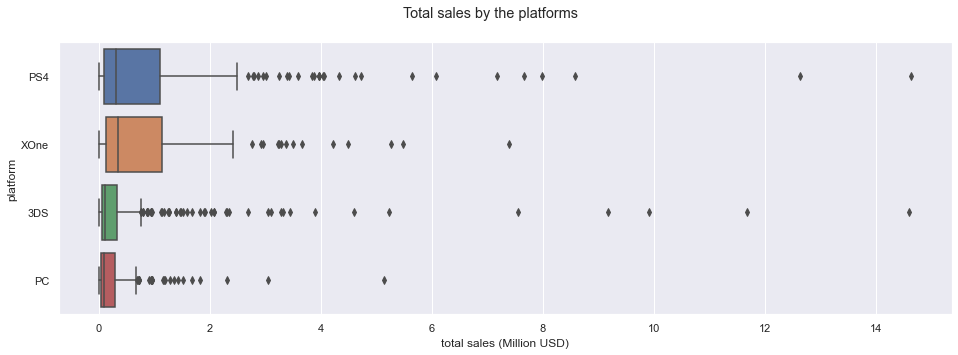

In [73]:
total_sales_suptitle = 'Total sales by the platforms'

plt.figure(figsize=(16, 5))
plt.suptitle(total_sales_suptitle)

sns.boxplot(x='total_sales', y='platform', data=games_tr, orient='h', order=top_relevant)
plt.xlabel(total_sales_label)

plt.show()

У платформ *PS4* и *3DS* есть несколько игр (2 и 4 соответственно), продажи которых кратно превосходят максимумы по *XOne* и *PC*. Возможно, они были выпущены только под первые две платформы. Их, а также другие выбросы рассмотрим более детально ниже.

В остальном картина у всех четырёх платформ - похожая: продажи 75% игр не превышают 0,3...1,1 млн. долл. в зависимости от платформы. Остальные 25% игр показали кратно больший объём продаж с разбросом, многократно превосходящим межквартильное расстояние. Разброс объёма продаж - очень широкий у всех платформ. Есть по несколько игр, лидирующих по объёму продаж с большим отрывом, и есть, наоборот, масса игр с "обычным" успехом на рынке.

#### Игры с небольшим объёмом продаж (выбросы отброшены)

Рассмотрим более детально игры с небольшим объёмом продаж. Для этого отсечём на графике правую часть. Изменится масштаб, и диаграммы станут нагляднее.

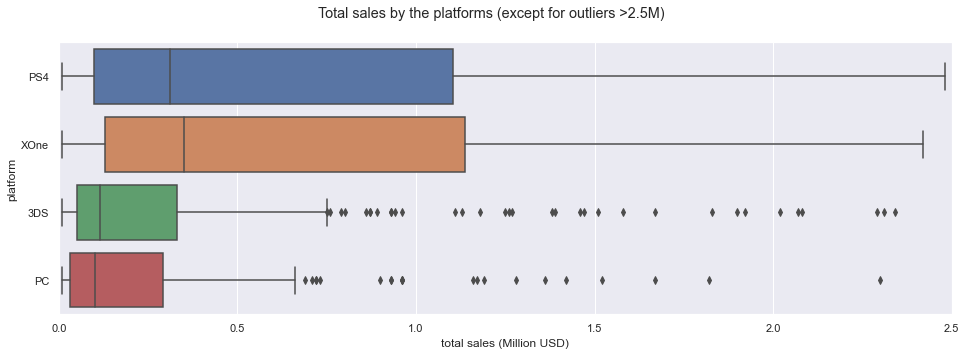

In [74]:
plt.figure(figsize=(16, 5))
outlier_bound = 2.50  # The big sales bound

plt.suptitle('{} (except for outliers >{}M)'.format(total_sales_suptitle, outlier_bound))

sns.boxplot(x='total_sales', y='platform', data=games_tr, orient='h', order=top_relevant)
plt.xlabel(total_sales_label)
plt.xlim(0, outlier_bound)

plt.show()

Говоря о среднем, в данном случае корректнее анализировать медиану, чем среднее арифметическое. Причина - необходимо устранить влияние описанного выше разброса.

Рассмотрим игры, входящие в первые три квартиля (от конца левого уса до правой границы ящика). В структуре продаж имеются следующие различия: **медианный объём продаж** первых двух платформ (***PS4*** и ***XOne***), а также их третий квартиль - примерно **втрое больше**, чем у последних двух (***3DS*** и ***PC***).

Можно предположить, что:
* игры  (версии одной и той же игры) для платформ *PS4* и *XOne* стоят дороже, чем для *3DS* и *PC*, или для *PS4* и *XOne* продаётся большее количество экземпляров игр;
* набор игр для платформ *PS4* и *XOne* отличается от набора игр для *3DS* и *PC* в большей степени, чем внутри каждой их этих пар.

Первый вывод проверить не получится, так как у нас нет информации о количестве проданных экземпляров каждой игры. А второй - можем проверить. Посчитаем, насколько пересекаются наименования игр для разных платформ.

In [75]:
# The function plots the heatmap for calculating the amount of the games existing in the same time
# for different pairs of the platforms

def comparison_heatmap(df, suptitle_suffix=0):
    df_pivot = df.pivot_table(index='name', columns='platform', values='genre', aggfunc='count') \
                .fillna(0) \
                .astype('int')
    cross = []
    for i in top_relevant:
        cross_i = []
        for j in top_relevant:
            cross_i.append(df_pivot[(df_pivot[i] == 1) & (df_pivot[j] == 1)].count().max())
        cross.append(cross_i)

    games_cross = pd.DataFrame(index=top_relevant, columns=top_relevant, data=cross)

    plt.figure(figsize=(5, 5))
    
    suptitle_suffix_dict = {
        0: '',
        1: '\n(outliers >{}M only)'.format(outlier_bound),
        2: '\n(except for outliers >{}M)'.format(outlier_bound)
    }
    suptitle = 'Amount of the identical games for pairs of the platforms' + suptitle_suffix_dict[suptitle_suffix]
    plt.suptitle(suptitle)

    sns.heatmap(games_cross, 
                cmap=sns.color_palette('coolwarm', 30),
                linewidth=0.1, 
                linecolor='whitesmoke', 
                square=True,
                vmax=df_pivot.sum().min(),
                annot=True,
                fmt='d')

    plt.yticks(rotation=0)
    plt.show()

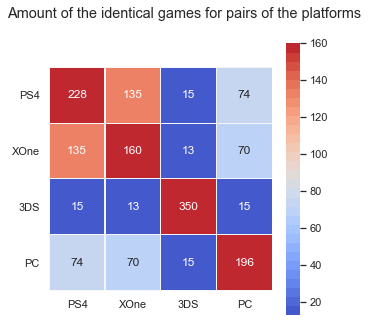

In [76]:
comparison_heatmap(games_tr)

Оба предположения подтвердились частично.

Больше всего пересекаются между собой наборы игр для *PS4* и *XOne* (84% игр для *XOne* существует также и для *PS4*; наоборот - 59%).

*РС* - "середнячок". В среднем 37% игр для него есть также на *PS4* и *XOne* (наоборот, соответственно, 32% и 44%).

А вот платформа *3DS*, как оказалось, имеет свои особые игры, которых в большинстве своём нет на других платформах. Только 7-8% игр для неё есть также на других платформах.

Поэтому первое предположение нужно сформулировать немного по-иному: **игры**, которые **выпускаются для *PS4*** и ***XOne***, дают **больший объём продаж**, чем игры, выпускаемые для ***3DS*** и ***PC***. Либо за счёт количества проданных экземпляров, либо за счёт более высоких цен на игры.

#### Игры с высоким объёмом продаж (только выбросы)

Рассмотрим игры с очень большим объёмом продаж - выбросы справа на боксплотах, которые не вошли в предыдущий подраздел.

In [77]:
games_tr_max_sales = games_tr.query('total_sales > @outlier_bound')
games_tr_max_sales_pivot = games_tr_max_sales.pivot_table(index='platform', 
                                                          values='total_sales', 
                                                          aggfunc=['count', 'max', 'mean', 'median']) \
                                             .droplevel(1, axis=1) \
                                             .sort_values(by='count', ascending=False)
games_tr_max_sales_pivot

,count,max,mean,median
platform,,,,
PS4,28,14.63,5.086429,3.965
3DS,14,14.60,6.105000,4.240
XOne,14,7.39,3.982143,3.435
PC,2,5.14,4.095000,4.095


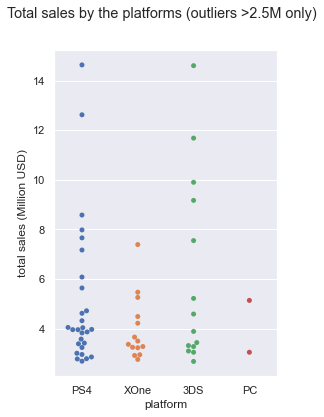

In [78]:
plt.figure(figsize=(4, 6))
plt.suptitle('{} (outliers >{}M only)'.format(total_sales_suptitle, outlier_bound))

sns.swarmplot(x=games_tr_max_sales.platform, y=games_tr_max_sales.total_sales, data=games_tr_max_sales, order=top_relevant)
plt.ylabel(total_sales_label)

plt.show()

Мы знаем только общий объём продаж каждой игры, а её стоимость и/или количество проданных экземпляров нам не известно. Поэтому мы можем говорить лишь в целом об успешности той или иной игры на рынке: много она денег принесла создателям или не очень.

Есть очень успешные игры, выбивающиеся даже среди самых продаваемых. Их - немного: 2 игры для *PS4* и 4 игры для *3DS*. Что это за игры, можно посмотреть в таблице в начале данного подраздела (пункт "*Формирование датасета*"). Остальные игры лежат кучнее. Можно заметить убывающую тенденцию: больше объём продаж - меньше таких игр.

Количество успешных игр по каждой платформе, объём их продаж, его среднее и медиана - в таблице выше. Медианы отличаются несильно; максимумы и средние - больше у тех платформ, где есть вышеописанные супервыбросы (они и образуют максимумы). Отметим и *PC*: для него выпустили всего две высокопродаваемые игры.

Сравним пересечение успешных игр у разных платформ.

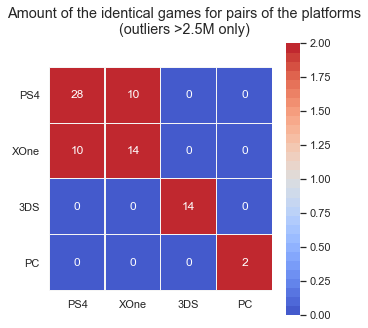

In [79]:
comparison_heatmap(games_tr_max_sales, suptitle_suffix=1)

**Больше всего успешных игр** оказалось среди выпущенных для ***PS4*** и ***XOne*** (28 и 14 соответственно). При этом 10 из них - **одни и те же**.

**Много успешных игр** и у ***3DS*** (14), но это - совсем **другие игры**.

Для персонального компьютера ***PC*** есть **только две** успешно продаваемых игры, и они тоже **не пересекаются** с другими платформами.

##  6. Влияние оценок  критиков и пользователей на продажи внутри одной популярной платформы

По результатам, полученным на предыдущих этапах исследования, самой популярной платформой по итогам 2015 года является Sony PlayStation ***PS4***. Её и рассмотрим в этом разделе.

Чтобы оценить, как связан объём продаж с оценками критиков и пользователей, необходимо построить соответствующие диаграммы рассеяния и рассчитать коэффициенты корреляции Пирсона.

Будем рассматривать только те игры, для которых известна оценка.

### Словари, списки, функции

In [80]:
# dicts
scatterplot_dict = {
    'critic_score': ['critics\''],
    'user_score'  : ['users\'']
}

chaddock = {
    0: [0.0, 0.1, 'отсутствует'],
    1: [0.1, 0.3, 'слабая'],
    2: [0.3, 0.5, 'умеренная'],
    3: [0.5, 0.7, 'заметная'],
    4: [0.7, 0.9, 'высокая'],
    5: [0.9, 1.0, 'весьма высокая']
}

In [81]:
# The function forms the dataset for researching the review influence

def review_research_dataset(platform, score):
    df = games_tr[ (games_tr['platform']==platform) & (games_tr[score]!=-1) & (games_tr[score]!=-2) ]
    df.reset_index(drop=True, inplace=True)
    print('Name of the platform: {}\nAmount of items: {}'.format(platform, len(df)))
    return df

In [82]:
# The function plots the scatterplot for researching the review influence

def review_research_scatterplot(df, score):
    plt.figure(figsize=(8, 8))
    plt.suptitle('Scatter diagram of the total sales by {} score'.format(scatterplot_dict[score][0]))
    
    sns.scatterplot(x=df[score], y=df['total_sales'], data=df)
    
    plt.xlabel('{} score'.format(scatterplot_dict[score][0]))
    plt.ylabel(total_sales_label)
    
    plt.show()

In [83]:
# The function computes the Pearson correlation coefficient and estimates the correlation level

def pearson(df, score, return_pcc=False):
    pcc = df[score].corr(df['total_sales']) #Pearson correlation coefficient (pcc)
    
    degree = ''
    for i in range(len(chaddock)):
        if chaddock[i][0] < abs(pcc) <= chaddock[i][1]:
            degree = chaddock[i][2]
            break
    
    relationship = ''
    if pcc > 0.1:
        relationship = ' положительная'
    elif pcc < -0.1:
        relationship = ' отрицательная'
    elif pcc == 0.0:
        relationship = 'отсутствует'
    
    if return_pcc:
        return pcc
    else:
        print('Коэффициент корреляции Пирсона: {:.3f}\nСвязь - {}{}'.format(pcc, degree, relationship))

### Влияние оценок критиков на объём продаж

Сформируем датасет, включающий только платформу *PS4* без условных "-1" в оценках критиков. Затем построим диаграмму рассеяния: ось X - оценки критиков; ось Y - объём продаж. Рассчитаем коэффициент корреляции.

Name of the platform: PS4
Amount of items: 154


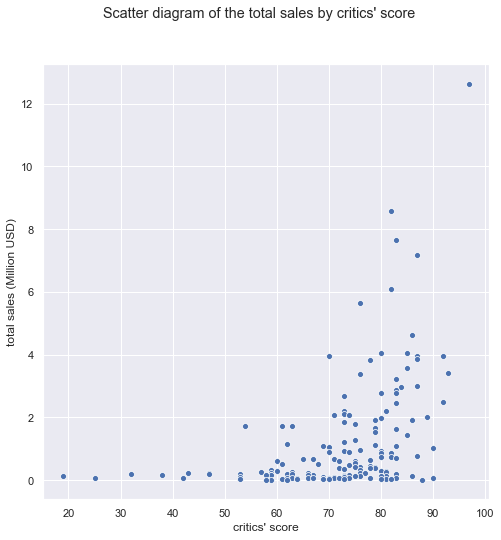

Коэффициент корреляции Пирсона: 0.432
Связь - умеренная положительная


In [84]:
games_tr_PS4 = review_research_dataset('PS4', 'critic_score')
review_research_scatterplot(games_tr_PS4, 'critic_score')
pearson(games_tr_PS4, 'critic_score')

Взаимосвязь определённо есть, но не понятно, что есть причина, а что - следствие: высокие ли оценки побуждают к покупке или высокое качество игры является причиной как хороших продаж, так и хороших оценок. В обоих случаях эти две величины связаны, но в первом они зависят друг от друга, а во втором - нет. Скорее всего, имеют место оба варианта: в каждом конкретном случае, принимая решение о покупке, пользователь может руководствоваться как мнением критиков, так и другими источниками (реклама, советы друзей и т.д.).

Диаграмма. Игры со скромным объёмом продаж получали самые разные оценки, от очень низких до очень высоких. Всё логично: их - много, и они - разные. Хорошая, по мнению экспертов, игра может иногда "не зайти" игрокам. А вот если не будет продаваться откровенно плохая, то это вполне предсказуемо. Игры с низкими и средними продажами (менее 2,5 млн. долл.), в основном, - "середнячки": 55-85 баллов.

Чем больше продажи, тем меньше разброс оценок, а сами оценки - выше. Если рассмотреть игры с продажами более 2,5 млн. долл., то видно, что хорошо продаваемая игра совершенно не обязательно будет удостоена самой высокой оценки: среди них также есть "середнячки".

В целом же эти величины имеют, как отмечено выше, **умеренную положительную связь**: больше продажи - выше оценка. И наоборот: выше оценка - больше продажи.

### Влияние оценок пользователей на объём продаж

Сформируем датасет, включающий только платформу *PS4* без условных "-1" и "-2" в оценках пользователей. Затем построим диаграмму рассеяния: ось X - оценки критиков; ось Y - объём продаж. Рассчитаем коэффициент корреляции.

Name of the platform: PS4
Amount of items: 156


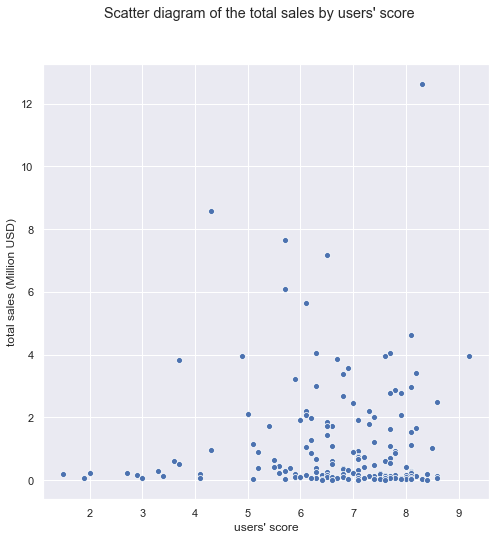

Коэффициент корреляции Пирсона: 0.024
Связь - отсутствует


In [85]:
games_tr_PS4 = review_research_dataset('PS4', 'user_score')
review_research_scatterplot(games_tr_PS4, 'user_score')
pearson(games_tr_PS4, 'user_score')

Более широкий разброс оценок при любом уровне объёма продаж обусловил околонулевое значение коэффициента корреляции и, как следствие, вывод об **отсутствии какой-либо взаимосвязи** между оценками пользователей и объёмом продаж.

Пользователи больше доверяют авторитетным персонам из мира игр, нежели рядовым геймерам. Низкая ценность оценок пользователей, вероятно, обусловлена высокой степенью их субъективности: непрофессионалу сложнее отделить объективное "качественно-посредственно" от эмоционального "понравилось лично мне или нет". Вряд ли обычный пользователь заморачивается с какими-то своими метриками оценок, чек-листами и прочим. В то время как у профессионального критика что-то подобное, хотя бы и "в уме", наверняка имеется.

Это отразилось на диаграмме. Успешные по продажам игры зачастую получают от пользователей очень низкие оценки. Ниже, чем у критиков. В то же время большая часть игр с низкими продажами оценивается в диапазоне 5,5-8,7, и можно предположить, что эти оценки несколько завышены. Возможно, пользователь чувствует большее разочарование (и ставит оценку ниже), если не понравившаяся ему игра обошлась дороже при покупке.

##  7. Влияние оценок  критиков и пользователей на продажи внутри других популярных платформ

Проведём аналогичные исследования (см. подраздел №6) для остальных популярных платформ: ***XOne***, ***3DS***, и ***PC***.

Name of the platform: XOne
Amount of items: 109


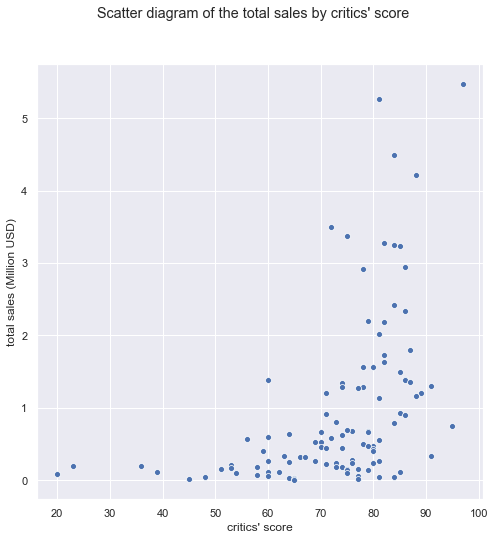

Коэффициент корреляции Пирсона: 0.459
Связь - умеренная положительная



Name of the platform: XOne
Amount of items: 116


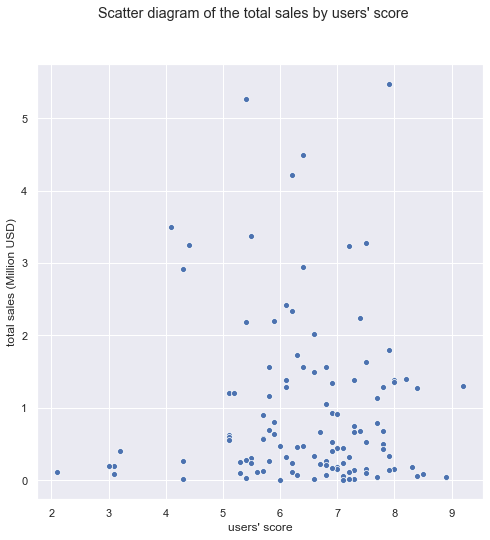

Коэффициент корреляции Пирсона: -0.039
Связь - отсутствует



Name of the platform: 3DS
Amount of items: 94


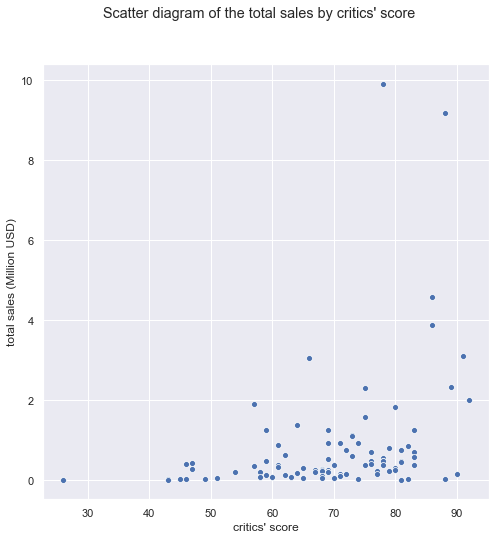

Коэффициент корреляции Пирсона: 0.333
Связь - умеренная положительная



Name of the platform: 3DS
Amount of items: 102


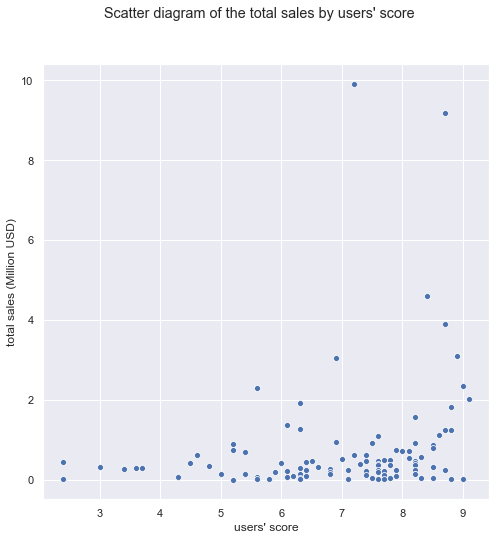

Коэффициент корреляции Пирсона: 0.211
Связь - слабая положительная



Name of the platform: PC
Amount of items: 153


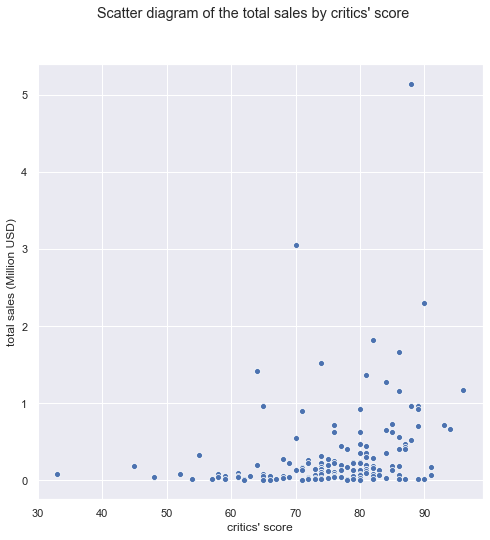

Коэффициент корреляции Пирсона: 0.263
Связь - слабая положительная



Name of the platform: PC
Amount of items: 161


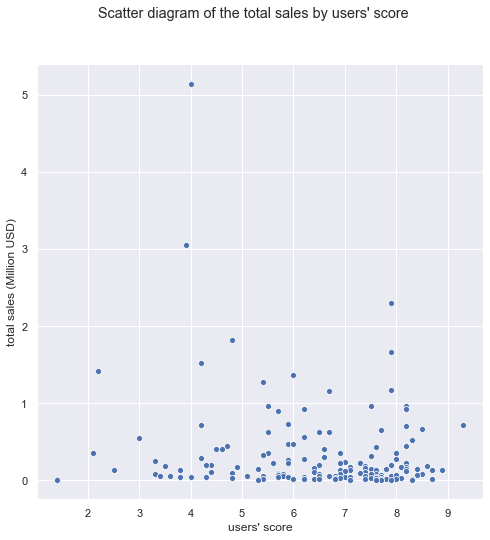

Коэффициент корреляции Пирсона: -0.159
Связь - слабая отрицательная





In [86]:
other_platforms = ['XOne', '3DS', 'PC']
scores = ['critic_score', 'user_score']

for platform in other_platforms:
    for score in scores:
        games_tr_platform = review_research_dataset(platform, score)
        review_research_scatterplot(games_tr_platform, score)
        pearson(games_tr_platform, score)
        for i in range(3):
            print('')

Выводы по этим трём платформам необходимо соотнести с выводами по платформе *PS4*.

##### XOne #####
Выводы по платформе *XOne* **аналогичны** выводам по платформе ***PS4***. Точки смотрятся более разреженно из-за меньшего размера выборки (на 30%).

##### 3DS #####
Взаимосвязь оценок **критиков** и объёма продаж у платформы *3DS* - **меньшая** по сравнению с платформой ***PS4***. В целом же, характеристики разброса у обеих платформ - похожи: есть многочисленные "середнячки", есть и большой разброс оценок в объёмах продаж выше 2,5 млн. долл.

А вот между **пользовательскими** оценками и объёмом продаж связь - хоть и **слабая**, но есть, и в этом заключается существенное отличие *3DS* от ***PS4***. Наличие связи обусловлено, согласно диаграмме, меньшим разбросом оценок среди высокопродаваемых игр. В целом, обе диаграммы (и по пользователям, и по критикам) у данной платформы похожи друг на друга.

Из-за, вероятно, более качественного пользовательского оценивания новые пользователи больше доверяют этим цифрам и охотнее на них опираются при покупке.

##### PC #####
В отличие от *PS4*, игры для персонального компьютера принесли своим создателям более 2,5 млн. долл. только в двух случаях. Критики оценили их по-разному: 70 и 88 баллов.

Большинство же остальных оценок **критиков** лежит широким разбросом в диапазоне от 60 до 95 баллов, и **чёткой взаимосвязи** там **нет**: среди этих игр есть как совсем непопулярные, так и продаваемые хорошо. Можно лишь отметить, что при более-менее высокой выручке, скажем, порядка 400-500 тыс. долл., не встречаются оценки ниже 60 баллов. В отличие от ***PS4***, в этом разбросе не угадывается какая-либо тенденция.

Оценки **пользователей** преподнесли сюрприз: большое количество средних оценок игр со средними продажами, а также неожиданно низкие оценки высокопродаваемых игр привели к **слабой отрицательной** связи. Связь - действительно слишком слабая, чтобы говорить о какой-либо зависимости. На диаграмме никаких тенденций также не просматривается. Вряд ли пользователей *PC* побуждают к покупке низкие оценки других геймеров. Остаётся лишь констатировать несколько неожиданные вкусы пользователей данной платформы. В остальном - **нет существенных различий** характера разброса от такового у ***PS4***.

##  8. Распределение игр по жанрам

Построим распределение продаж игр для топовых платформ за актуальный период по жанрам.

In [87]:
grouped_by_genre = games_tr.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
grouped_by_genre

genre
Action          167.09
Shooter         125.50
Role-Playing    116.40
Sports           68.84
Simulation       29.19
Platform         25.07
Misc             24.62
Racing           20.65
Fighting         16.49
Adventure        11.11
Strategy          7.26
Puzzle            2.71
Name: total_sales, dtype: float64

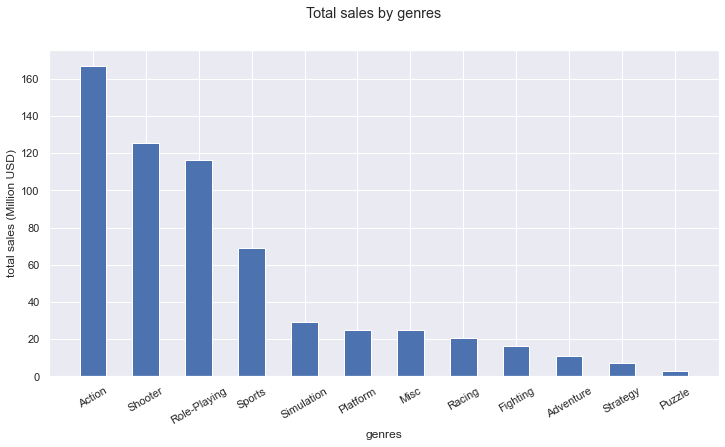

In [88]:
plt.figure(figsize=(12, 6))
plt.suptitle('Total sales by genres')

plt.bar(grouped_by_genre.index, grouped_by_genre, width=0.5)
plt.xlabel('genres')
plt.xticks(rotation=30)
plt.ylabel(total_sales_label)

plt.show()

**Самые прибыльные** жанры - ***Action***, ***Shooter***, ***Role-Playing***, ***Sports***. Они лидируют с большим отрывом: разница между первым и четвёртым местом среди них - в 2,4 раза. И точно такая же разница лишь только между *Sports* и следующим за ним *Simulation*.

Далее - похожим образом. Плавное от жанра к жанру, но по итогу - четырёхкратное снижение от *Simulation* до *Strategy*. И, наконец, ***Puzzle*** - самый непопулярный жанр - показал продажи почти втрое ниже, чем идущий перед ним *Strategy*. То есть занял с довольно большим отрывом **последнее место**.

Самый прибыльный жанр *Action* показал продажи **в 62 раза больше**, чем самый малоприбыльный *Puzzle*. Два порядка.

Особенность самых популярных жанров состоит в том, что они больше, чем другие, приспособлены для командных игр по сети. И в целом игры этих жанров - более динамичные и эмоциональные.

##  Вывод по исследовательскому анализу данных

Проанализирована **динамика выпуска игр по годам**. Выделены характерные периоды с различной динамикой, последний из которых (с 2012 года) представляется актуальным.

Проанализирована **динамика изменения объёма продаж по годам в разрезе платформ**. Определены максимальные продажи (и топовые платформы) за всё рассматриваемое время среди всех платформ: 100-200 млн. долл. (в разные годы - *Sony PlayStation* 1-4 поколений, *Nintendo Wii* и *Microsoft Xbox 360*). Определён период наибольших продаж на протяжении жизненного цикла платформы: со второго по пятый годы её существования (или примерно первая треть - вторая четверть времени жизни). Средняя продолжительность жизни платформы составляет 8 лет.

**Актуальный период** по совокупности полученных результатов определён как 2012-2015 годы включительно. Не вошёл в актуальный период последний, 2016-й год, так как данные за него - неполные. К актуальному периоду относятся 14,5% данных.

Рассмотрена **динамика продаж в актуальном периоде**. Определены потенциально прибыльные платформы: лидирующие по продажам и активно растущие *PS4* и *XOne*; умеренно снижающаяся, но показывающая высокие продажи *3DS*; стабильный и предсказуемый с точки зрения рынка *PC*, который в 2016 году, согласно имеющимся данным, претендует на 4-е место по продажам, а также опережает *XOne* по разнообразию игр.

Проведено **исследование глобальных продаж игр в актуальном периоде для топовых платформ**. По всем четырём платформам продажи 75% игр не превышают 0,3...1,1 млн. долл.; продажи остальных 25% - кратно выше, а их разброс многократно превосходит межквартильное расстояние. Медиана и третий квартиль объёма продаж платформ *PS4* и *XOne* втрое больше, чем у *3DS* и *PC*. Исследовано пересечение игр у платформ. Пара *PS4* и *XOne* имеет больше всего пересечений: 84% игр для *XOne* существуют также в версии для *PS4*. Игры для *PC* пересекаются с *PS4* и *XOne* в 37% случаев. Игры для платформы *3DS* пересекаются с остальными только в 7-8% случаев. В сегменте выше 2,5 млн. долл. игры для платформ *PS4* и *XOne* пересекаются примерно в половине случаев, а *3DS* и *PC* не пересекаются ни с ними, ни между собой. Это позволило сделать вывод о том, что те игры, которые были выпущены для *PS4* и *XOne*, дают больший объём продаж, чем те, что для *3DS* и *PC*. Это происходит либо за счёт количества проданных экземпляров, либо за счёт более высоких цен.

Изучено **влияние оценок критиков и пользователей на продажи внутри платформы *PS4***. Оценка критиков связана с объёмом продаж умеренной положительной связью: коэффициент корреляции Пирсона (далее - pcc) равен 0.432. Выше оценка - больше продажи. Вероятно, имеют место одновременно две ситуации: 1) высокая оценка повлияла на решение о покупке; 2) высокая оценка и решение о покупке не зависят друг от друга, а обусловлены высоким качеством той или иной игры. Оценка пользователей и объём продаж не взаимосвязаны (pcc=0.024). Имеются как низкие оценки успешных игр, так и высокие оценки игр с небольшими продажами.

Изучено **влияние оценок критиков и пользователей на продажи по остальным трём платформам** в сравнении с *PS4*. По платформе *XOne* ситуация аналогична *PS4*: умеренная положительная связь продаж с оценками критиков (pcc=0.459) и отсутствующая - с оценками пользователей (pcc=-0.039) У платформы *3DS* оценка критиков связана с объёмом продаж в меньшей степени, чем у *PS4* (pcc=0.333), а оценка пользователей, - наоборот, в большей (pcc=0.211). У *PC* и оценка критиков, и оценка пользователей связаны с продажами слабо (соответственно pcc=0.263 и pcc=-0.159). Весьма необычно, что у *PC* связь продаж с оценкой пользователей - отрицательная: пользователи *PC* зачастую ставят успешным в продажах играм низкие оценки. Характер разброса при этом похож на разброс у *PS4*.

Определены **наиболее прибыльные жанры** - *Action*, *Shooter*, *Role-Playing*, *Sports*. Наименее прибыльный - *Puzzle*. Продажи *Action* по сравнению с *Puzzle* больше в 62 раза. Игры популярных жанров в большей степени приспособлены для командных игр по сети, а это сейчас интересно пользователю. Также их можно охарактеризовать как в целом более динамичные и эмоциональные.

# Портрет пользователя каждого региона

## Выбор датасета

В данном разделе мы будем использовать датасет *games_relevant*, который включает в себя данные только за актуальный период. Дальнейший анализ будем проводить именно по этому периоду.

При этом никакие платформы из датасета не выбрасываются: нам необходимо составить топ-5 по регионам, и региональные топы могут отличаться от тех, что мы выявили ранее, когда исследовали суммарные продажи по всем регионам. Не будем сужать выбор искусственно.

In [89]:
games_relevant.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_cat,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,4,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,4,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,-1,-1,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1,-1.0,-1,-1,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83,5.3,M,4,13.79


### Словари, списки, функции

In [90]:
# regions list
regions = ['NA', 'EU', 'JP']
reg_cols = ['na_sales', 'eu_sales', 'jp_sales']

In [91]:
# The function forms the pivot table of the total sales by the regions for the relevant period splitting by the platforms

def region_sales_pivot(df, column_name):
    df_pivot = df.pivot_table(index=column_name, 
                              values=reg_cols, 
                              aggfunc='sum')

    df_pivot = df_pivot.rename(columns={reg_cols[0]: regions[0], 
                                        reg_cols[1]: regions[1], 
                                        reg_cols[2]: regions[2]})

    return df_pivot[regions]

In [92]:
# The function visualizes the pivot table descrbted above ('region_sales_pivot')

def region_sales_heatmap(df, column_name, transpose=True, colors=12, width=16):
    # dicts
    column_name_dict = {
        'platform'  : ['the platforms'],
        'genre'     : ['the genres'],
        'rating'    : ['rating ESRB'],
        'rating_cat': ['rating ESRB']
    }
    
    # general sets
    plt.figure(figsize=(width, 10))
    plt.suptitle('Sales in the regions by {} and by years'.format(column_name_dict[column_name][0]))
    
    if transpose == True:
        df = df.transpose()
    
    # heatmap
    plt.subplot(211)
    sns.heatmap(df, 
                cmap=sns.color_palette('coolwarm', colors),
                vmax=df.max().mean(),
                linewidth=0.1,
                square=True,
                linecolor='whitesmoke',
                annot=True,
                fmt='.2f')

    plt.ylabel('region')
    plt.xlabel(column_name)
    plt.yticks(rotation=0)
    
    # barplot
    plt.subplot(212)
    bar_legend = []
    for i in range(len(regions)):
        plt.bar(df.columns, df.iloc[i], width=(i+1)*0.2, alpha=0.5)
        bar_legend.append(regions[i])

    plt.legend(bar_legend)
    plt.ylabel('sales (Million USD)')
    plt.xlabel(column_name)
    plt.yticks(rotation=0)
    
    # show
    plt.show()

In [93]:
# The function forms the rating by sales

def top_five(df):
    top = []
    for region in regions:
        top.append(df[region].sort_values(ascending=False).head().index.tolist())
    
    range_size = 6
    if len(df) < 5:
        range_size = len(df) + 1
    
    return pd.DataFrame(index=regions, columns=range(1,range_size,1), data=top).transpose()

## Определение самых популярных платформ по регионам (топ-5)

Для того, чтобы определить самые популярные платформы, нужно сравнивать между собой суммы продаж по каждой платформе за актуальный период.

Почему суммы за период, а не продажи только за последний год? Год, указанный в данных, - это год выпуска игры. Как уже было отмечено в одном из предыдущих разделов, игра, выпущенная однажды, продолжает продаваться и после того, как завершится год её выпуска. Соответственно, продолжает использоваться и платформа для неё. Мы не знаем, какой объём продаж отражён в данных: за год выпуска или за всё время существования игры. Если в таблице имеется в виду объём продаж игры за всё время, то иной подход, нежели суммирование за актуальный период, будет некорректным. А если имеются в виду продажи лишь за год выпуска, то тогда это уже вопрос к логике сбора данных. Но и в этом случае, какой бы ни был указан объём продаж, игра (а вместе с ней и платформа) продолжает использоваться какое-то время и после года выпуска. Значит, будет правильнее судить о популярности той или иной платформы по сумме продаж за период. Такой подход, вероятно, более близок к действительности, чем отождествление года продажи игры и периода популярности платформы под неё.

Составим сводную таблицу суммарных продаж по каждому региону за актуальный период с разбивкой по платформам.

In [94]:
region_sales_platform = region_sales_pivot(games_relevant, column_name='platform')
region_sales_platform.transpose()

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
NA,51.17,4.59,17.76,102.71,87.25,0.13,10.83,17.39,36.00,139.36,78.85
EU,40.31,3.53,34.23,105.60,109.31,0.42,10.97,11.81,23.65,73.81,41.96
JP,79.76,3.72,0.00,33.99,10.22,10.47,17.48,3.39,12.34,1.57,0.33


Визуализируем её.

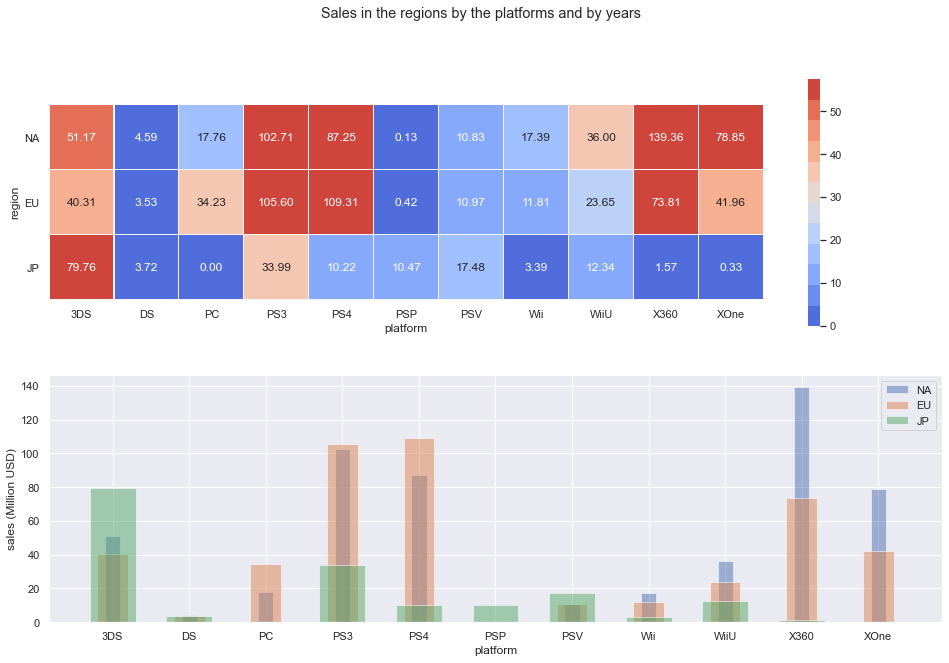

In [95]:
region_sales_heatmap(region_sales_platform, column_name='platform')

Определим топ-5 платформ по каждому региону.

In [96]:
top_five(region_sales_platform)

,NA,EU,JP
1,X360,PS4,3DS
2,PS3,PS3,PS3
3,PS4,X360,PSV
4,XOne,XOne,WiiU
5,3DS,3DS,PSP


Предпочтения **в Европе и Северной Америке - достаточно схожие**. Япония отличается от них куда существеннее.

**В Европе и Северной Америке** в топ-5 входят **одни и те же** платформы. В Америке ***X360*** любят больше, чем *PlayStation*, а в Европе - наоборот. В Америке, в отличие от Европы, ***PS3*** популярнее, чем ***PS4***. На **четвёртом** месте в **обоих** регионах - платформа ***XOne***. На предыдущем этапе исследования она оценена как перспективная. Если поклонники *X360* пересядут на неё, как на более свежую платформу от *Microsoft*, то вполне возможно, что продажи по ней увеличатся. ***3DS*** **замыкает** топ-5 в **обоих** регионах.

**В Японии**, как это часто бывает, всё **совершенно не так**, как в остальном мире. Японцы в восторге от своего Nintendo: ***3DS*** у них **лидирует** с большим отрывом. А **в Европе и Северной Америке** эта платформа, как мы уже знаем, - лишь на **пятом** месте с вдвое меньшими продажами. **PS4*** вообще не попала в пятёрку (6 место), немного уступив ***PSP***: возможно, некоторые из её потенциальных покупателей успели сделать выбор в пользу ***3DS***, которая вышла немного раньше. Ещё в Японии любят ***PSV*** и ***WiiU***: **3 и 4 места**. Интересно: продажи *PSV* в Европе и Америке в полтора раза меньше, чем в Японии, а вот игры для *WiiU*, напротив, продаются там соответственно вдвое и втрое большим объёмом в абсолютном выражении.

В целом ещё можно отметить, что пользователи **в Европе и Северной Америке** предпочитают **стационарные** игровые платформы, а **в Японии** - **портативные**, которые можно носить с собой.

## Определение самых популярных жанров по регионам (топ-5)

Действовать будем аналогично предыдущему подразделу: чтобы определить самые популярные жанры, нужно сравнивать между собой суммы продаж по каждому жанру за актуальный период.

Жанровые предпочтения пользователей вряд ли сильно зависят от того, насколько популярна та или иная платформа. Тем более, многие игры имеют версии для разных платформ. Вкусы большинства людей не меняются резко каждые 1-2 года - они более-менее постоянные.

Поэтому для того, чтобы выявить самые популярные жанры, будем ориентироваться на суммы продаж по жанрам за весь актуальный период.

Составим сводную таблицу суммарных продаж по каждому региону за актуальный период с разбивкой по жанрам.

In [97]:
region_sales_genre = region_sales_pivot(games_relevant, column_name='genre')
region_sales_genre.transpose()

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
NA,168.55,7.97,17.95,37.43,24.09,1.13,16.49,58.11,128.53,7.81,73.99,3.99
EU,148.66,8.14,9.45,25.66,20.02,1.39,25.52,44.25,97.57,13.28,57.08,4.58
JP,45.73,7.06,8.69,11.82,8.52,2.14,2.49,58.83,8.17,10.08,7.09,2.65


Визуализируем её.

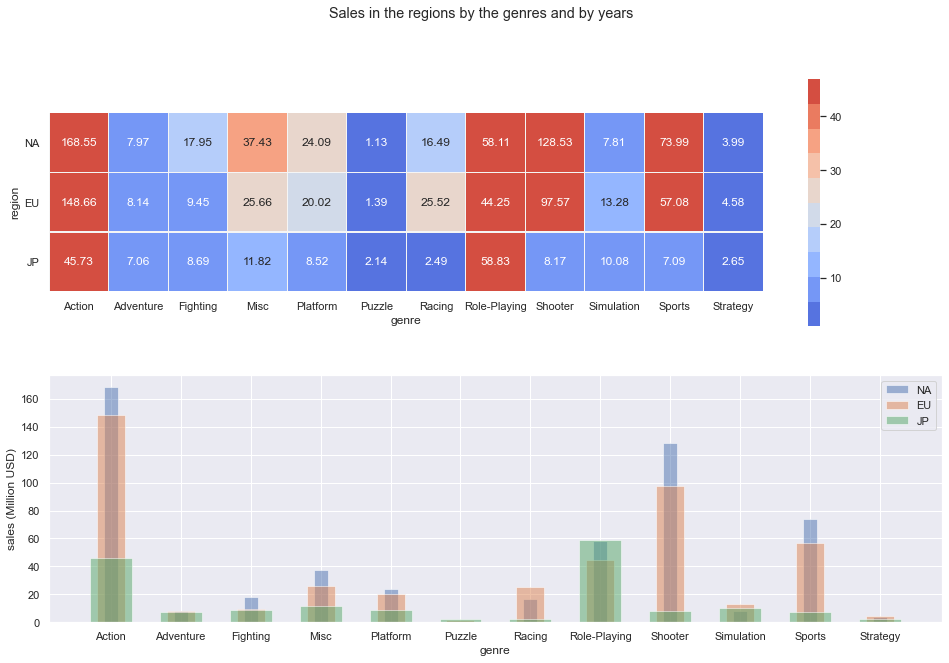

In [98]:
region_sales_heatmap(region_sales_genre, column_name='genre', colors=10)

Определим топ-5 жанров по каждому региону.

In [99]:
top_five(region_sales_genre)

,NA,EU,JP
1,Action,Action,Role-Playing
2,Shooter,Shooter,Action
3,Sports,Sports,Misc
4,Role-Playing,Role-Playing,Simulation
5,Misc,Misc,Fighting


Сходства и различия - как и в платформах: схожие (идентичные!) Европа и Америка и совершенно другая Япония.

В Европе и Северной Америке первые три места занимают жанры, предполагающие активное участие игрока, динамичность, эмоциональность, зрелищность. Причём первые два - *Action* и *Shooter* - опередили *Sports* с двухкратным отрывом. *Role-Playing* и *Misc* ("Misc", к слову, означает "Разное") тоже популярны, но немного менее.

В Японии самый популярный жанр - *Role-Playing*. За ним идёт *Action*. Остальные жанры - позади с многократным отрывом. В частности, *Shooter*, популярный в Америке и Европе, в Японии даже не вошёл в топ-пятёрку (7 место), и популярность его на этом рынке ниже в 12-15 раз.

## Влияние рейтинга ESRB на продажи в регионах

Сформируем датасет. Для этого уберём из исходного (того же, что использовался в предыдущих подразделах) датасета *games_relevant* строки, в которых отсутствует рейтинг ESRB (в столбце *rating_cat* стоит значение "-1").

In [100]:
games_relevant_esrb = games_relevant[games_relevant['rating_cat'] != -1]

Влияние рейтинга ESRB на объёмы продаж мы будем исследовать так же, как в предыдущих подразделах: сравнивать между собой суммы продаж по каждой категории за актуальный период.

Для начала приведём категории рейтинга:
* *Е* - старше 6 лет;
* *Е10+* - старше 10 лет;
* *Т* - старше 13 лет;
* *М* - старше 17 лет.

Есть и некоторые другие категории, но они встречаются крайне редко, и в рассматриваемой выборке их нет.

Рейтинг ESRB - это категория ограничения по возрасту. Он показывает, с какого возраста можно играть в ту или иную игру. Если возраст пользователя - меньше, то играть ему, соответственно, не рекомендуется.

Учитывая это, уместнее говорить не о влиянии рейтинга, а, скорее, о предпочтениях аудитории: в каком регионе какие игры больше всего любят. Возрастное ограничение может стать причиной отказа от покупки (если возраст не соответствует), но вряд ли послужит причиной её совершения. Пользователь не будет дополнительно мотивирован к покупке, если узнает, что проходит по возрасту согласно рейтингу ESRB.

С другой стороны, если игре присвоен "детский" рейтинг, это не всегда означает, что такая игра предназначена для детей. Это всего лишь говорит об отсутствии неприемлемого для детей контента (например, сцены насилия, сквернословие, демонстрация обнажённого тела и т.д.). К примеру, рейтинг "*Е*" (6+) обычно присваивают таким играм, как шахматы.

С точки зрения предпочтений пользователей рейтинг ESRB в чём-то аналогичен жанру игры: каждый пользователь имеет некоторые конкретные предпочтения, какие игры ему нравятся, и игры эти, будучи похожими друг на друга, будут, вероятно, иметь одинаковый или близкий рейтинг. Реалистичные шутеры - это одно. Стратегии - это другое.

Предпочтения пользователей не меняются быстро, тем более в масштабах рынка целого региона, поэтому изучать их предпочтения мы будем так же по суммам продаж по категориям рейтинга ESRB за весь актуальный период.

Составим сводную таблицу суммарных продаж по каждому региону за актуальный период с разбивкой по категориям рейтинга ESRB.

In [101]:
# The categories order set in ascending of the age category
rating_order = ['E', 'E10+', 'T', 'M']

region_sales_esrb = region_sales_pivot(games_relevant_esrb, column_name='rating')
region_sales_esrb = region_sales_esrb.transpose()[rating_order]
region_sales_esrb

rating,E,E10+,T,M
NA,106.40,71.89,57.07,215.90
EU,99.42,51.56,43.17,177.42
JP,27.26,7.74,23.75,20.00


Визуализируем её.

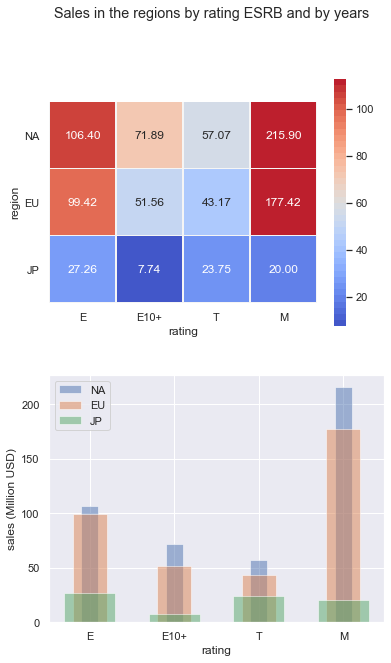

In [102]:
region_sales_heatmap(region_sales_esrb, column_name='rating', transpose=False, colors=40, width=6)

Составим рейтинг по убыванию популярности категорий в каждом регионе.

In [103]:
top_five(region_sales_esrb.transpose())

,NA,EU,JP
1,M,M,E
2,E,E,T
3,E10+,E10+,M
4,T,T,E10+


Снова похожая картина: совпадающие Северная Америка и Европа и отличающаяся от них Япония.

Рейтинг категорий рейтинга ESRB (без тавтологии не обошлось) перекликается с полученным выше рейтингом жанров. Категория "*М*" - игры жанров *Action* и *Shooter*, категория "*Е*" - *Sports* и *Role-Playing*. У Японии тоже просматривается соответствие.

Посмотрим, действительно ли взаимосвязаны жанр и рейтинг ERSB.

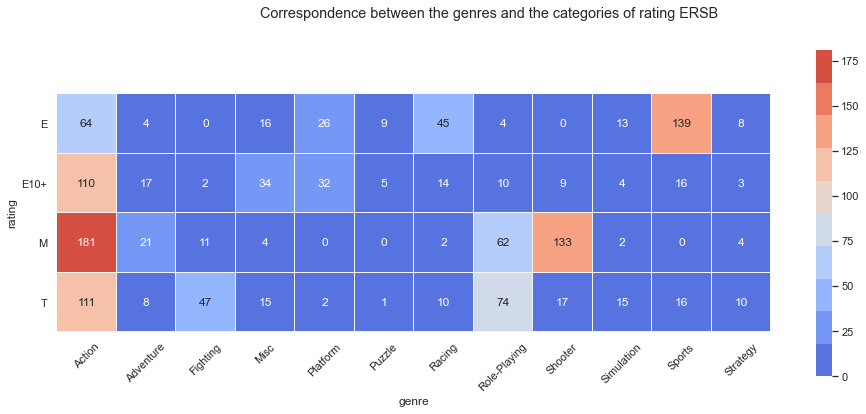

In [104]:
genre_rating_match = games_relevant_esrb.pivot_table(index='genre', columns='rating', values='name', aggfunc='count')
genre_rating_match = genre_rating_match.fillna(0).astype('int')

plt.figure(figsize=(16, 6))
plt.suptitle('Correspondence between the genres and the categories of rating ERSB')

sns.heatmap(genre_rating_match.transpose(), 
            cmap=sns.color_palette('coolwarm', 10),
            linewidth=0.1, 
            linecolor='whitesmoke', 
            square=True,
            annot=True,
            fmt='d')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

Действительно, мы видим, что некоторым жанрам в большинстве случаев соответствуют определённые категории. Для жанра *Action* - категория "*М*" (также есть и много других, но "*М*" - преобладает); для *Shooter* - тоже "*М*"; для *Sports* - "*E*"; для *Role-Playing* - "*М*" и "*Т*". Примерно всё сходится.

Получается, что предпочтения пользователей (и, следовательно, объёмы продаж) относительно различных категорий рейтинга ESRB на самом деле обусловлены жанровыми предпочтениями.

## Вывод по исследованию портрета пользователя каждого региона

Для проведения исследования портрета пользователя по регионам используются **данные за актуальный период по всем платформам**, которые в это время существовали. 

**Платформы**. В Северной Америке тройка лидеров - *X360*, *PS3* и *PS4*. В Европе - они же, но в обратном порядке. Далее - *XOne* и *3DS* в обоих регионах. В Японии - совершенно иные предпочтения: лидер - *3DS*. Второе место - совпадает: *PS3*. Далее - *PSV*, *WiiU*, *PSP*. В Америке и Европе больше любят стационарные платформы, а в Японии - портативные.

**Жанры**. Предпочтения в Америке и Европе полностью совпадают. Первые места - *Action* и *Shooter*. Затем, с отрывом, - *Sports* и *Role-Playing*. Американцы и европейцы любят динамичные жанры. В Японии предпочтения - совсем иные. Первые два места - *Role-Playing* и *Action*. Остальные жанры следуют с большим отрывом. Японцы предпочитают игры поспокойнее.

**Рейтинг ESRB**. Рейтинг ESRB - это, по сути, метка ограничения по возрасту. Главный вывод здесь заключается в том, что данный рейтинг тесно связан с жанрами, особенно с теми, что оказались наиболее популярными. Предпочтения в рейтинге на самом деле являются предпочтениями в жанрах. При этом рейтинг ESRB как независимая величина может повлиять на решение о покупке лишь в качестве ограничивающего фильтра, а как побуждающий стимул - нет.

Североамериканский и европейский пользователи **очень похожи друг на друга** в своих предпочтениях. А пользователь из Японии - **отличается** от них весьма сильно.

# Проверка гипотез

## Вводная часть

### Подход к формулированию гипотез

На основе формулировки гипотезы, изложенной в техническом задании, необходимо строго сформулировать нулевую (H<sub>0</sub>) и альтернативную (H<sub>1</sub>) гипотезы - те, с которыми мы будем непосредственно работать.

Нулевая гипотеза должна быть сформулирована так, чтобы использовать знак равенства. Альтернативная гипотеза должна быть противоположна нулевой.

### Применяемые критерии

Для проверки гипотезы о равенстве средних двух генеральных совокупностей, когда распределения - нормальные или близкие к таковым, применяется t-критерий Стьюдента (выполняется Т-тест Стьюдента).

При выполнении Т-теста Стьюдента учитывается равенство или неравенство дисперсий двух рассматриваемых выборок. Равенство дисперсий не обязательно должно быть строгим: достаточно приблизительного равенства, схожести.

В тех случаях, когда равенство (приблизительное) дисперсий не очевидно, применяется тест Ливиня. Тест Ливиня позволяет достоверно установить, можно ли считать дисперсии двух выборок равными или нет. В случаях, когда равенство или неравенство очевидно, можно обойтись и без этого теста.

Необходимо отметить, что оба теста весьма робастны (устойчивы) к скошенности выборок.

#### Интерпретация результатов теста Стьюдента

* ***p-value > &alpha;*** - эмпирически полученные данные не противоречат нулевой гипотезе; H<sub>0</sub> не отвергается.
* ***p-value &le; &alpha;*** - эмпирически полученные данные противоречат нулевой гипотезе; H<sub>0</sub> отвергается и принимается H<sub>1</sub>.

#### Интерпретация результатов теста Ливиня

* ***p-value > &alpha;*** - дисперсии сравниваемых распределений значений статистически достоверно не различаются.
* ***p-value &le; &alpha;*** - дисперсии сравниваемых распределений значений статистически достоверно различаются.

### Уровень значимости

Зададим подходящий для данного типа задач уровень значимости, единый для всего проекта. Приемлемым представляется уровень &alpha; = 0,05.

In [105]:
alpha = 0.05

### Подготовка данных

Сформируем датасет. Возьмём за основу датасет *games_relevant*, который включает в себя данные только за актуальный период. 

Поскольку нас интересует столбец *user_score*, необходимо оставить только те строки, где он заполнен, а с пропусками - удалить. "tbd" в данном случае тоже следуем признать пропуском. Пропуски и "tbd" заменены в датасете соответственно на "-1" и "-2".

In [106]:
games_hyp = games_relevant[ (games_relevant['user_score']!=-1) & (games_relevant['user_score']!=-2) ]
games_hyp.reset_index(drop=True, inplace=True)
games_hyp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 13 columns):
name               1268 non-null object
platform           1268 non-null object
year_of_release    1268 non-null int32
genre              1268 non-null object
na_sales           1268 non-null float64
eu_sales           1268 non-null float64
jp_sales           1268 non-null float64
other_sales        1268 non-null float64
critic_score       1268 non-null int32
user_score         1268 non-null float64
rating             1268 non-null object
rating_cat         1268 non-null int64
total_sales        1268 non-null float64
dtypes: float64(6), int32(2), int64(1), object(4)
memory usage: 119.0+ KB


### Словари, списки, функции

In [107]:
# tuples
platforms = ('XOne', 'PC')
genres = ('Action', 'Sports')
score_range = range(0, 11)
score_lim = (0, 10)

# strings
score_xlabel = 'users\' score'
fd_ylabel = 'frequency'
pdf_ylabel = 'probability density'

# dicts
test_results_dict = {
    'levene' : ['Дисперсии НЕ различаются', 'Дисперсии различаются'],
    'student': ['Данные НЕ противоречат нулевой гипотезе', 'Данные противоречат нулевой гипотезе']
}

hyp_set = {
    1: ['platforms', platforms],
    2: ['genres', genres]
}

In [108]:
# The function sets the format of the axis

def subplot_format(subplot_number):
    plt.xticks(score_range)
    plt.xlim(score_lim)
    plt.xlabel(score_xlabel)
    
    if subplot_number == 1:
        plt.ylabel(fd_ylabel)
    elif subplot_number == 2:
        plt.ylabel(pdf_ylabel)

In [109]:
# The function implements the Levene test

def levene(sample, out=True, out_str=True):
    results = st.levene(sample[0], sample[1])
    var_is_equal = None
    res_str = ''
    
    if results.pvalue > alpha:
        res_str = test_results_dict['levene'][0]
        var_is_equal = True
    else:
        res_str = test_results_dict['levene'][1]
        var_is_equal = False
    
    if out_str:
        print('p-value: {}\nalpha:   {:.3f}\n{}'.format(results.pvalue, alpha, res_str))
    if out:
        return var_is_equal

In [110]:
# The function implements the Student t-test

def student(sample, var_is_equal=True):
    results = st.ttest_ind(sample[0], sample[1], equal_var=var_is_equal)
    res_str = ''
    
    if results.pvalue > alpha:
        res_str = test_results_dict['student'][0]
    else:
        res_str = test_results_dict['student'][1]
    
    print('p-value: {}\nalpha:   {:.3f}\n{}'.format(results.pvalue, alpha, res_str))

In [111]:
# The function displays properties of samples

def sample_properties(sample):
    size = []
    mean = []
    var = []
    std = []

    for i in range(2):
        size.append(len(sample[i]))
        mean.append(np.mean(sample[i]))
        var.append(np.var(sample[i]))
        std.append(np.std(sample[i]))
        print('Sample {}:\nsize     : {}\nmean     : {}\nvariance : {}\nstd. dev.: {}\n'
              .format(i+1, size[i], mean[i], var[i], std[i]))

    print('variance ratio: {} ({})'.format(var[0]/var[1], var[1]/var[0]))

In [112]:
# The function draws the statistical plots

def stat_plot_func(sample, hyp_number):
    plt.figure(figsize=(16, 8))
    
    plt.suptitle('Distribution of the users\' score for the {} {} and {}'
                 .format(hyp_set[hyp_number][0],
                         hyp_set[hyp_number][1][0],
                         hyp_set[hyp_number][1][1]
                        )
                )

    # subplot 1
    plt.subplot(121)
    plt.title('Frequency distribution')
    legend = []
    for i in range(2):
        sns.distplot(sample[i], bins=20, kde=False)
        legend.append(hyp_set[hyp_number][1][i])
    subplot_format(1)
    plt.legend(legend)

    # subplot 2
    plt.subplot(122)
    plt.title('Kernel density estimation')
    legend = []
    for i in range(2):
        sns.kdeplot(sample[i], shade=True)
        legend.append(hyp_set[hyp_number][1][i])
    subplot_format(2)
    plt.legend(legend)

    plt.show()

## Гипотеза 1. О рейтингах платформ

### Формулирование нулевой и альтернативной гипотез

Приведём формулировку гипотезы из технического задания.
* Средние пользовательские рейтинги платформ *Xbox One* и *PC* - одинаковые.

Во избежание разночтений сразу обозначим *Xbox One* как *XOne* - название этой платформы в соответствии с данными.

Сформулируем нулевую и альтернативную гипотезы.
* **H<sub>0</sub>** - средние пользовательских рейтингов платформ *XOne* и *PC* равны.
* **H<sub>1</sub>** - средние пользовательских рейтингов платформ *XOne* и *PC* не равны.

### Формирование выборок и вычисление их характеристик

Сформируем выборки. Найдём среднее, дисперсию и стандартное отклонение каждой выборки. Также рассчитаем соотношение дисперсий двух выборок.

In [113]:
sample = []
for platform in platforms:
    sample.append(games_hyp.user_score[games_hyp['platform'] == platform])

sample_properties(sample)

Sample 1:
size     : 116
mean     : 6.477586206896552
variance : 1.6451872770511302
std. dev.: 1.28264853995595

Sample 2:
size     : 161
mean     : 6.465217391304348
variance : 2.694069673237915
std. dev.: 1.6413621395773434

variance ratio: 0.6106699070903512 (1.637545895727339)


### Построение графиков распределений частот и функций плотности вероятности

Построим для обеих выборок гистограммы распределения частот и функции плотности вероятности.

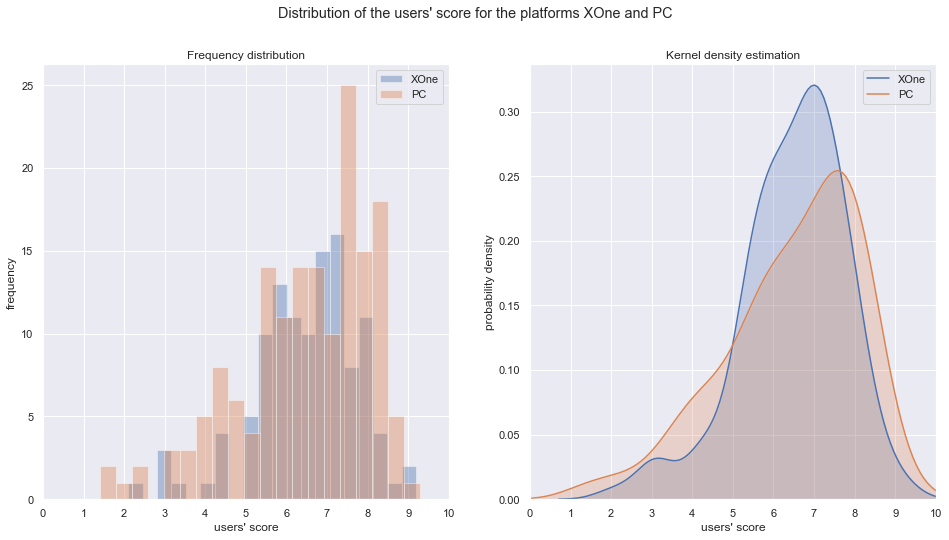

In [114]:
stat_plot_func(sample, 1)

Обе выборки имеют скошенность вправо. Тем не менее, их распределения достаточно близки к нормальным для выполнения статистических тестов (робастность тестов допускает такую скошенность).

Гистограммы "неровные" из-за малого размера выборок - в них всего 116 и 161 элемент.

Функции оценки плотности вероятности различаются, но из графиков не вполне очевидно, можно ли считать дисперсии равными или нет.

### Проверка гипотезы

Для того, чтобы результаты t-теста Стьюдента были точными, сначала необходимо определить, равны (близки) ли дисперсии или нет.
* Разница дисперсий - существенная (var. ratio = 1,64), но различаются дисперсии всё же не на порядок.
* Гистограммы, как и kde-графики, имеют некоторые различия; но, тем не менее, в целом они - достаточно схожи.

Поскольку имеются сомнения, выполним тест Ливиня.

In [115]:
var_is_equal = levene(sample)

p-value: 0.007378897272236593
alpha:   0.050
Дисперсии различаются


Выполним t-тест Стьюдента с учётом результатов теста Ливиня.

In [116]:
student(sample, var_is_equal)

p-value: 0.9441751855931831
alpha:   0.050
Данные НЕ противоречат нулевой гипотезе


Результат t-теста Стьюдента означает, что мы **не можем отвергнуть** нулевую гипотезу. Но и **подтвердить** её тоже **не можем**, так как высока вероятность **случайного** совпадения средних двух выборок. Можно даже сказать, что вероятность этого - очень высокая, так как p-value стремится к единице. Интерпретировать результат следует как возможное равенство двух средних - точно это **не известно**. Важно иметь в виду, что **различия**, даже будучи несущественными относительно характеристик распределения, могут быть всё равно **существенными** для нас. Высокая вероятность совпадения **не тождественна** малой величине различия между средними.

Оценивая в совокупности результат t-теста Стьюдента и предшествующие ему расчёты и построения, можно сделать вывод о том, что **средние** пользовательских рейтингов платформ *XOne* и *PC*, весьма вероятно, **схожи** между собой.

## Гипотеза 2. О рейтингах жанров

### Формулирование нулевой и альтернативной гипотез

Приведём формулировку гипотезы из технического задания.
* Средние пользовательские рейтинги жанров *Action* и *Sports* - разные.

Сформулируем нулевую и альтернативную гипотезы.
* **H<sub>0</sub>** - средние пользовательских рейтингов жанров *Action* и *Sports* равны.
* **H<sub>1</sub>** - средние пользовательских рейтингов жанров *Action* и *Sports* не равны.

### Формирование выборок и вычисление их характеристик

Сформируем выборки. Найдём среднее, дисперсию и стандартное отклонение каждой выборки. Также рассчитаем соотношение дисперсий двух выборок.

In [117]:
sample = []
for genre in genres:
    sample.append(games_hyp.user_score[games_hyp['genre'] == genre])

sample_properties(sample)

Sample 1:
size     : 438
mean     : 6.861187214611872
variance : 1.8276259877817393
std. dev.: 1.3518971809208493

Sample 2:
size     : 157
mean     : 5.461146496815286
variance : 2.780337539048237
std. dev.: 1.6674344182150724

variance ratio: 0.657339607912272 (1.5212836530207368)


### Построение графиков распределений частот и функций плотности вероятности

Построим для обеих выборок гистограммы распределения частот и функции плотности вероятности.

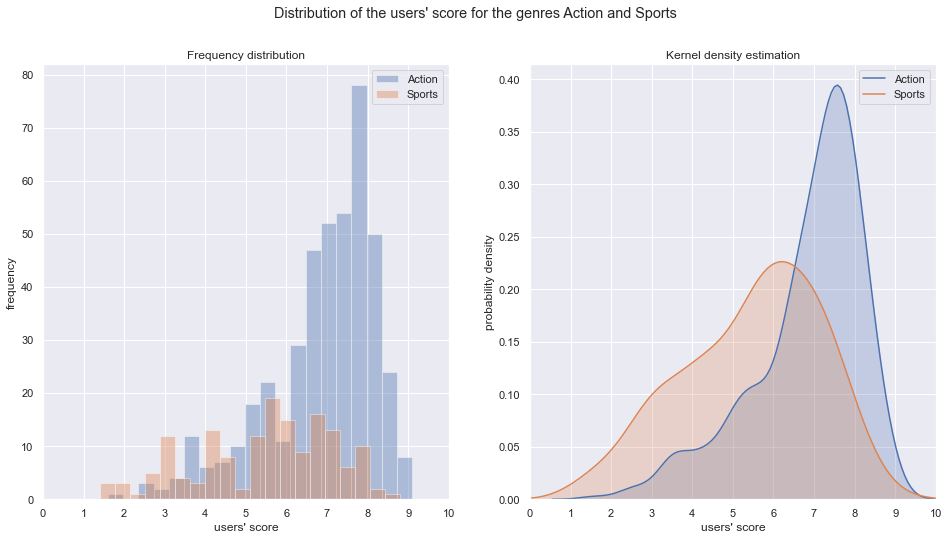

In [118]:
stat_plot_func(sample, 2)

Обе выборки имеют скошенность вправо. Тем не менее, их распределения достаточно близки к нормальным для выполнения статистических тестов (робастность тестов допускает такую скошенность).

Гистограмма *Sports* "неровная" из-за малого размера выборки - 157 элементов. В выборке *Action* - 438 элементов, и поэтому её гистограмма - более сглаженная.

Функции оценки плотности вероятности различаются достаточно существенно, и, скорее всего, дисперсии не равны.

### Проверка гипотезы

Для того, чтобы результаты t-теста Стьюдента были точными, сначала необходимо определить, равны (близки) дисперсии или нет.
* Разница дисперсий - существенная (var. ratio = 1,52), но немного менее, чем у выборок по платформам (предыдущий подраздел).
* И гистограммы, и kde-графики имеют существенные различия.

То, что дисперсии двух выборок различаются, - достаточно очевидно. Однако, нет никаких препятствий выполнить тест Ливиня, чтобы стопроцентно в этом убедиться.

In [119]:
var_is_equal = levene(sample)

p-value: 0.00010830327943170913
alpha:   0.050
Дисперсии различаются


Выполним t-тест Стьюдента с учётом результатов теста Ливиня.

In [120]:
student(sample, var_is_equal)

p-value: 4.070626122768134e-18
alpha:   0.050
Данные противоречат нулевой гипотезе


Результат t-теста Стьюдента говорит об экстремально **малой вероятности** того, что нулевая гипотеза **верна**. Уверенно **отвергаем её** и принимаем альтернативную гипотезу: **средние** пользовательских рейтингов жанров *Action* и *Sports* **не равны**.

## Вывод по проверке гипотез

**Подготовительный этап**: дано описание подходов к формулированию гипотез, описание применяемых критериев для их проверки, приведены правила интерпретации результатов. Также был задан уровень значимости &alpha; и подготовлен датасет, из которого впоследствии формировались выборки.

**Гипотеза 1**. Гипотеза о равенстве средних пользовательских рейтингов платформ *XOne* и *PC* по результату t-теста Стьюдента не отвергнута. При этом она не может быть и подтверждена. Средние рейтинги, возможно, близки статистически (хотя есть высокая вероятность того, что подобный результат - случайность), но с практической стороны они могут различаться всё равно существенно. В итоге, можно утверждать лишь то, что равенство средних не исключено. Если же результат проверки гипотезы рассмотреть в совокупности с данными характеристик распределений и графиками, то можно предположить, что средние пользовательских рейтингов платформ *XOne* и *PC* схожи между собой.

**Гипотеза 2**. Гипотеза о равенстве средних пользовательских рейтингов жанров *Action* и *Sports* отвергнута. Результат t-теста Стьюдента говорит о крайне низкой вероятности того, что гипотеза верна. В связи с этим была принята альтернативная гипотеза о неравенстве средних, и был сделан вывод о том, что средние пользовательских рейтингов жанров *Action* и *Sports* не равны. Остальные результаты так же говорят об этом.

# Общий вывод

##### Предобработка данных #####

На этапе предобработки исходные данные были приведены в пригодное для дальнейшего анализа состояние. Удалены строки с критичными пропусками, обработаны - с некритичными. Выполнено приведение типов, добавлены необходимые столбцы.

Данные изначально были в хорошем состоянии, а большинство недостатков обусловлено характером данных, а не качеством их сбора. Отдельно проанализированы причины возникновения пропусков в столбцах с рейтингами.

##### Исследовательский анализ данных #####

Исследовательский анализ проводился относительно глобальных объёмов продаж. По результатам анализа динамики выпуска игр по годам и динамики изменения объёма продаж по годам в разрезе платформ определён **актуальный период** для прогноза на 2017 год: 4 года (2012-2015). 2016 год не вошёл в него из-за неполноты данных.

Определёна **характерная длительность жизненного цикла** платформы: 8 лет.

По результатам анализа динамики продаж в актуальном периоде определены **потенциально прибыльные** платформы: *PS4*, *XOne*, *3DS*, *PC*. По ним отдельно проведён анализ динамики продаж, в результате которого установлено, что для *PS4* и *XOne* существуют такие игры (версий этих игр для других платформ нет), которые обеспечивают самые большие продажи - ценой или тиражом.

Исследовано влияние оценок критиков и пользователей на продажи внутри платформы *PS4*. Оценки критиков умеренно связаны с продажами, а оценки пользователей - не связаны. Влияние оценок на продажи исследовано также и по остальным топовым платформам. В целом, мнение **критиков** ценится пользователями **выше**, чем мнение других **пользователей**. Недоверие, вероятно, связано с недостаточной объективностью оценки непрофессионалами.

Определены наиболее **прибыльные жанры** - *Action*, *Shooter*, *Role-Playing*, *Sports*. Наименее прибыльный - *Puzzle*. Продажи *Action* по сравнению с *Puzzle* различаются в 62 раза.

##### Портрет пользователя каждого региона #####

Исследовались различия в продажах по регионам - Северная Америка, Европа, Япония. В актуальном периоде рассматривались предпочтения пользователей в платформах, жанрах, а также исследовалось влияние рейтинго ESRB.

**В Северной Америке и Европе** предпочтения оказались **схожими** (а иногда и идентичными) по всем рассмотренным вопросам. Предпочтения же пользователя из **Японии** - совершенно **другие**. Америка и Европа - это стационарные приставки и динамичные жанры. Япония - это портативные платформы и ролевые игры.

Рейтинг ESRB сам по себе не побуждает пользователя к покупке, так как это - всего лишь отметка о возрастных ограничениях. Но он **тесно связан с жанрами**, поэтому предпочтения той или иной категории рейтинга на самом деле в большинстве случаев являются жанровыми предпочтениями.

##### Проверка гипотез #####

Выполнена проверка двух гипотез. В техническом задании они сформулированы следующим образом:
* Средние пользовательские рейтинги платформ *Xbox One* и *PC* - одинаковые;
* Средние пользовательские рейтинги жанров *Action* и *Sports* - разные.

Для проверки гипотезы о равенстве средних двух независимых выборок используется критерий Стьюдента (проводится t-тест Стьюдента). Для получения более точного результата необходимо проверить равенство дисперсий двух выборок, для чего используется критерий Ливиня (тест Ливиня). Результат сравнивается с р-уровнем значимости и интерпретируется.

Гипотеза о равенстве средних пользовательских рейтингов платформ *XOne* и *PC* по результату t-теста Стьюдента не отвергнута. По совокупности полученных результатов можно предположить, что **средние** пользовательских рейтингов **платформ *XOne* и *PC* схожи** между собой.

Гипотеза о равенстве средних пользовательских рейтингов жанров *Action* и *Sports* по результату t-теста Стьюдента отвергнута. Остальные данные также позволяют утверждать, что **средние** пользовательских рейтингов **жанров *Action* и *Sports* различаются**.

##### Заключение #####

Сформулируем закономерности, определяющие успешность игры.
* Лучше ориентироваться на новые, хорошо раскрученные платформы, нежели на устаревшие и непопулярные. Нужно учитывать срок жизни платформы.
* Не обязательно стремиться покрыть версиями все существующие платформы - достаточно топовых и хорошо прогнозируемых.
* Прибыльность жанров может различаться на два порядка. Стоит обратить внимание на наиболее прибыльные.
* Необходимо учитывать региональные особенности предпочтений пользователей. Они могут сильно различаться.